# Notebook for a Downstream RNA-Seq Analysis

Hello, this analysis workflow will enable you to process an existing RNA-Seq feature count matrix. At this point, you should have a feature count matrix (e.g. an nf-core rna-seq pipeline output), a TPM matrix, a design file and a model file to specify details for your differential gene expression comparisons. 

## Requirements
- A feature count matrix file (e.g. output of the nf-core rnaseq pipeline)
- A TPM file (e.g. output of the nf-core rnaseq pipeline)
- A design file specifiying the experimental design
- A model file specifying the statistical model for differential gene expression analyses

In this example, those files are read from the ../../../../data folder. 

## Outputs
Any pdf result figures this pipeline will produce by default (Heatmaps, MA-plots, volcano plots) will be deposited in the ../../../../outputs/html_local/report_figures folder. 

Feel free to add additonal modules to this data analysis. These days chatGPT does a great job at providing R-code templates for additional figures you might like to see in this analysis. 

# Getting Started

To run this notebook, please use the R422 kernel. This should aready be running an R422 should be visible in the top-right hand corner of this screen. 

If it is not, go to the Kernel tab > Change kernel and select R422 from the dropdown menu. 

The kernel specifications are as follows:

<ul>
<li>name: R422</li>
<li>channels:</li>
<li>  - conda-forge</li>
<li>dependencies:</li>
 <li> gcc_linux-64</li>
 <li> gfortran_linux-64</li>
 <li> gxx_linux-64</li>
 <li> r-base=4.2.2</li>
 <li> r-renv</li>
 <li> r-irkernel</li>
</ul>

Dataset used in this analysis: https://www.ebi.ac.uk/ena/browser/view/PRJEB23709
Alignment was done with Unison pipeline: [reference to pipeline]




In [62]:
# RNA-Seq pipeline outputs were transferred to the/data folder in this project
print(paste0("Input files for this project are located in the data folder: ", paste0(list.files("../../../../data"), collapse = ", ")))

[1] "Input files for this project are located in the data folder: rsem.all.gene_counts.tsv, rsem.all.gene_TPM.tsv"


# Creating or Loading the R-renv Environment for this Analysis
To ensure reproducibility of this analysis we'll use the R-packaging manager renv. It will allow us to keep track of R-packages and their versions, to ensure that this analysis is fully reproducible. For this example analysis, an renv environment has been created already. 

In [63]:
## Load renv environment ##

###############################################################################
##                                                                           ##
if (!requireNamespace("remotes")){
  install.packages("remotes")
}


if (!requireNamespace("renv")){
  remotes::install_github("rstudio/renv")
}

if (!file.exists("renv.lock")){
    renv::init()
} else {
    renv::restore(prompt = FALSE)
}

## Done                                                                      ##
###############################################################################

* The library is already synchronized with the lockfile.


# Setting Parameters for this Analysis

In [64]:
###############################################################################
## Set project parameters                                                    ##

projectList <- list()

## First dataset
projectList[["First_RNAseq_Dataset"]] <- list(
    "dataset_id" =  "PRJEB23709",
    "primaryAlignmentGeneID" = "gene_id",
    "geneIDcolumn" = "gene_id",
    "datasetTitle" = "NEM dataset",
    "datasetAbstractURL" = "",
    "sampleSheetFile" = "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/samplesheet.csv",
    "designFile" = NULL, # if you have a design file, provide a path here.
    "modelFile" = NULL,
    "multiQChtmlFile" = "path/To/Individual/MultiQC",
    "geneLevelFeatureCountFile" = "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_counts.tsv",
    "geneLevelTPMfile" = "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_tpm.tsv"
    )


project_id <- "RNA_Seq_NEM_Analysis_001"
primaryAlignmentGeneID <- "gene_id"
geneIDcolumn <- "gene_id"
NtopGenes <- 500

projectTitle <- "RNAseq NEM Analysis"
projectSubtitle <- "Analysis GSE209801"

projectAbstract <- "Examination of the effect of NEM treatment on cells"

projectAuthor <- "John Doe"

projectDir <- paste0(getwd(), "/")

workdir <- paste0("../../../../workdir/")

if (!dir.exists(workdir)){
    dir.create(workdir, recursive = TRUE)
}

htmlDir <- paste0("../../../../results/html_local/")

if (!dir.exists(htmlDir)){
    dir.create(htmlDir, recursive = TRUE)
}

tableDir <- paste0(htmlDir, "report_tables/")

if (!dir.exists(tableDir)){
    dir.create(tableDir)
}

figDir <- paste0(htmlDir, "report_figures/")

if (!dir.exists(figDir)){
    dir.create(figDir, recursive = TRUE)
}

figureCount <- 1

tableCount <- 1



## Done                                                                      ##
###############################################################################

# Create a design and model file for all experiments in this analysis
## Creating a design file


In [65]:
# Create design file based on sample sheet - manual editing required - 

for (i in 1:length(projectList)){
    if (is.null(projectList[[i]][["designFile"]])){
        sampleSheetFN <- projectList[[i]][["sampleSheetFile"]]
        dfSample <- read.delim(
            sampleSheetFN, 
            sep = ",",
            stringsAsFactors = F
        )

        dfDesign <- dfSample
        dfDesign[["sample.group"]] <- dfDesign[["sample"]]

        ## create comparisons ##
        
        
        names(dfDesign) <- gsub("^sample$", "sample.id", names(dfDesign))
        
        dfDesign$sample.group <- gsub("_[1-9]$", "",dfDesign$sample.group)

        dfDesign <- dfDesign[,c("sample.id", "sample.group")]

        dfDesign <- dfDesign[order(dfDesign$sample.group, decreasing = T), ]

        mComb <- combn(unique(dfDesign$sample.group),2)
       
        for (j in 1:ncol(mComb)){
            tag <- paste0("comp_", j)
            dfDesign[,tag] <- ""
            groupA <- mComb[1, j]
            groupB <- mComb[2,j]

            dfDesign[dfDesign$sample.group == groupA, tag] <- paste0("1_", groupA)
            dfDesign[dfDesign$sample.group == groupB, tag] <- paste0("2_", groupB)
        }
            print(dfDesign) 
        
         designFN <- paste0("../../design/design.table.dataset.",i,".txt")  
        write.table(dfDesign, designFN, sep="\t", row.names=F)
        projectList[[i]][["designFile"]] <- designFN
        print(paste0("Design file for experiment ", i, " written to file: ", designFN, ". You can open the design file and edit it before proceding. "))
    }
}


     

      sample.id sample.group        comp_1
1 NEN_treated_2  NEN_treated 1_NEN_treated
2 NEN_treated_3  NEN_treated 1_NEN_treated
5 NEN_treated_1  NEN_treated 1_NEN_treated
3        DMSO_2         DMSO        2_DMSO
4        DMSO_1         DMSO        2_DMSO
6        DMSO_3         DMSO        2_DMSO
[1] "Design file for experiment 1 written to file: ../../design/design.table.dataset.1.txt. You can open the design file and edit it before proceding. "


# Loading of input files for this Workflow
## Loading the Design File

In [66]:
###############################################################################
## Create Design file for combined dataset                                   ##

# This module reads 
#   * a design file
#   * a model file 
#   * a RSEM read count matrix (rnaseq pipeline output)

# and produces the differential gene expression analyses specified in the 
# design/model files. 

# Outputs: DEseqw differential gene epxression output, written out as a text 
# file. 

# Load individual design files and create a combined desing file

designFileList <- list()

for (i in 1:length(projectList)){
    FNdesign <- projectList[[i]]$designFile
    print(FNdesign)

    if (file.exists(FNdesign)){
        dfDesign <- read.delim(
            FNdesign, 
            header = TRUE, 
            sep = "\t",
            stringsAsFactor = FALSE
        )

        if (!is.null(projectList[[i]]$dataset_id) & !(projectList[[i]]$dataset_id == "")){
            dfDesign[["dataset_id"]] <- projectList[[i]]$dataset_id
        } else {
            dfDesign[["dataset_id"]] <- paste0("dataset_", i)
        }

        if (nrow(dfDesign) > 0){
            designFileList[[names(projectList)[i]]] <-   dfDesign
        }

        print(
            paste0(
                "Design file loaded for project ",
                names(projectList)[i],
                "."
            )
        )
    }

        
      
}

lapply(designFileList, dim)


[1] "../../design/design.table.dataset.1.txt"
[1] "Design file loaded for project First_RNAseq_Dataset."


$First_RNAseq_Dataset
[1] 6 4

In [67]:
## Carry over all DGE comparisons defined in individual datasets
for (i in 1:length(designFileList)){
    names(designFileList[[i]]) <- gsub("comp_", paste0("comp_", LETTERS[i]), names(designFileList[[i]]))
}

## Carry over all DGE comparisons defined in individual datasets
for (i in 1:length(designFileList)){
    names(designFileList[[i]]) <- gsub("LRT_", paste0("LRT_", LETTERS[i], "_"), names(designFileList[[i]]))
}

## Carry over all factors defined in individual datasets
for (i in 1:length(designFileList)){
    names(designFileList[[i]]) <- gsub("f_", paste0("f_", LETTERS[i], "_"), names(designFileList[[i]]))
}

lapply(designFileList, names)

###############################################################################
## Unify design files                                                        ##

# Find common columns
colList <- lapply(designFileList, colnames)
commonCols <- Reduce(intersect, colList)

print(commonCols)
# Now create a vector with all columns that are present in at least one dataset

relevantCols <- as.vector(NULL, mode="character")

for (i in 1:length(designFileList)){
    pos <- c(
        grep("comp_", names(designFileList[[i]])),
        grep("f_", names(designFileList[[i]])),
        grep("LRT_", names(designFileList[[i]]))
    )
    relevantCols <- c(
        relevantCols, 
        names(designFileList[[i]])[pos]
    )
}



$First_RNAseq_Dataset
[1] "sample.id"    "sample.group" "comp_A1"      "dataset_id"

[1] "sample.id"    "sample.group" "comp_A1"      "dataset_id"  


In [68]:
## Missing relevant cols to all design files in the list so they can be combined
for (i in 1:length(designFileList)){
    missingCols <- relevantCols[!(relevantCols %in% names(designFileList[[i]]))]
    dfAdd <- data.frame(
        matrix(nrow = nrow(designFileList[[i]]), ncol=length(missingCols))
    )
    names(dfAdd) <- missingCols

    designFileList[[i]] <- cbind(
        designFileList[[i]],
        dfAdd
    )

    if (i ==1){
        mergedDesignFile <- designFileList[[i]][,c(commonCols, relevantCols)]
    } else {
        mergedDesignFile <- rbind(
            mergedDesignFile,
            designFileList[[i]][,c(commonCols, relevantCols)]
        )
    }
}

pos <- grep("\\.1$", names(mergedDesignFile))
if (length(pos) > 0){
    mergedDesignFile <- mergedDesignFile[,-pos]
}

## Show unified design table
DT::datatable(mergedDesignFile)                          

HTML widgets cannot be represented in plain text (need html)

In [69]:
###############################################################################
## Optional: Add cross dataset DGE instructions                              ##

# unique(mergedDesignFile$sample.group)

# mergedDesignFile[["comp_1"]] <- ""

# responder <- c(
#     "CompleteR_F",
#     "CompleteR_M",
#     "CTLA4plusPD1_R",
#     "PartR_F",
#     "PartR_M",
#     "PD1_R"
# )

# nonResponder <- c(
#     "CTLA4plusPD1_NR",
#     "PD1_NR",
#     "ProgD_F",
#     "ProgD_M",
#     "PD1_NR"
# )

# mergedDesignFile[mergedDesignFile$sample.group %in% responder, "comp_1"] <- "Responder"
# mergedDesignFile[mergedDesignFile$sample.group %in% nonResponder, "comp_1"] <- "NonResponder"

##
###############################################################################

## For this example, cutting down to must DGE comp_1

# allComps <- c(
#     names(mergedDesignFile)[grep("comp_", names(mergedDesignFile))],
#     names(mergedDesignFile)[grep("LRT_", names(mergedDesignFile))]
# )

# removeCols <- allComps[allComps != "comp_1.1"]

                            
# mergedDesignFile <- mergedDesignFile[,!(names(mergedDesignFile) %in% removeCols)  ]
                            
## Show unified design table
# DT::datatable(mergedDesignFile)  

In [70]:
################################################################################
## Save design file                                                           ##
FNdesign <- "../../design/design.table.txt"

write.table(
    mergedDesignFile,
    FNdesign,
    row.names = F,
    sep = "\t"
)

print("Merged design file saved.")

## Merged design file saved                                                   ##
################################################################################

[1] "Merged design file saved."


In [71]:
###############################################################################
## Create model files                                                        ##

# If you already have a model file, just add the path to the file at the bottom
# of this section. In this case, there is no need to create the file using this
# template.
dfDesign <- mergedDesignFile

print(dfDesign)

comparisonID <- c(
    names(dfDesign)[grep("comp_", names(dfDesign))]
)
comparison <- rep("", length(comparisonID))
for (i in 1:length(comparisonID)){
    contrasts = sort(as.vector(unique(dfDesign[,comparisonID[i]])), decreasing = FALSE)
    contrasts = contrasts[contrasts != ""]

    contrasts <- gsub("^1_", "", contrasts)
    contrasts <- gsub("^2_", "", contrasts)

    #Create contrast vector
    #contrast.vector = c([condition],[1_diff.gene set, e.g. mt],[2_baseline, e.g. wt])
    #if (contrasts[2] != "scr"){
    #  contrasts = rev(contrasts)
    #}
    
    if (length(contrasts) > 0){
        sel.col = contrasts

        contrast.vector = append("condition", contrasts)
        colName = paste(contrasts, collapse = "_vs_")
        comparison[i] <- colName  
    } else {
        comparison[i] <- gsub("comp_", "", comparisonID[i])
    }
    
}

test <- rep("Wald", length(comparison))
type <- rep("DGE", length(comparison))

model <- rep("~ condition", length(comparison))

## You might need to replace the above model vector with a bespoke model
# for each comparison
# example for an experiment with 5 comparisons
# model <- c(
#     "~ condition",
#     "~ condition + f_timepoint + condition:f_timepoint",
#     "~ condition + f_timepoint + condition:f_timepoint",
#     "~ condition + f_timepoint + condition:f_timepoint",
#     "~ condition + f_timepoint + condition:f_timepoint"
# )

## Reduced model not relevant for a DGE, but a column that needs to be present
reducedModel <- rep("", length(comparison))

## Normalise all samples together, or just those involved in the DGE comparison
normalizeAllSamplesTogether <- rep(FALSE, length(comparison))
betaPrior <- rep(TRUE, length(comparison))


dfModel <- data.frame(
    comparison,
    comparisonID,
    test,
    type,
    model,
    reducedModel,
    normalizeAllSamplesTogether,
    betaPrior, stringsAsFactors = TRUE
)


## Now add the LRT part
comparisonID <- names(dfDesign)[grep("LRT_", names(dfDesign))]
comparison <- names(dfDesign)[grep("LRT_", names(dfDesign))]

## Use conditon as stand-in for the variable to do LRT on. 

if (length(comparison) > 0){
        test <- rep("LRT", length(comparison))
        type <- rep("LRT", length(comparison))
        model <- rep("~ condition", length(comparison))
        reducedModel <- rep("~1", length(comparison))
        normalizeAllSamplesTogether <- rep(FALSE, length(comparison))
        betaPrior <- rep("", length(comparison))



        dfMLRT <- data.frame(
            comparison,
            comparisonID,
            test,
            type,
            model,
            reducedModel,
            normalizeAllSamplesTogether,
            betaPrior,
            stringsAsFactors = FALSE
        )

        dfModel <- rbind(
            dfModel,
            dfMLRT
        )
}

dfModel[is.na(dfModel)] <- ""

modelFN <- "../../design/model.table.txt"

write.table(
    dfModel ,
    modelFN , 
    row.names = FALSE, 
    sep = "\t"
)


## Done model file                                                           ##
###############################################################################

## Show unified design table
DT::datatable(dfModel) 

      sample.id sample.group       comp_A1 dataset_id
1 NEN_treated_2  NEN_treated 1_NEN_treated PRJEB23709
2 NEN_treated_3  NEN_treated 1_NEN_treated PRJEB23709
3 NEN_treated_1  NEN_treated 1_NEN_treated PRJEB23709
4        DMSO_2         DMSO        2_DMSO PRJEB23709
5        DMSO_1         DMSO        2_DMSO PRJEB23709
6        DMSO_3         DMSO        2_DMSO PRJEB23709


HTML widgets cannot be represented in plain text (need html)

In [72]:
###############################################################################
## Create merged read count matrix                                           ##
countFileList <- list()
fileType <- "geneLevelFeatureCountFile"

for (i in 1:length(projectList)){
    FNcount <- projectList[[i]][[fileType]]
    print(FNcount)

    if (file.exists(FNcount)){
        dfRSEM <- read.delim(
            FNcount, 
            header = TRUE, 
            sep = "\t",
            stringsAsFactor = FALSE
        )

        ## Remove extra column
        dfRSEM$transcript_id.s. <- NULL
        
        if (nrow(dfRSEM) > 0){
            countFileList[[names(projectList)[i]]] <-   dfRSEM
        }

        print(
            paste0(
                "Design file loaded for project ",
                names(projectList)[i],
                "."
            )
        )
    }

        
      
}

lapply(countFileList, dim)

###############################################################################
## Create one single featureCount matrix                                     ##



for (i in 1:length(countFileList)){
    dfTemp <- countFileList[[names(projectList)[i]]]

    if (i == 1){
        dfRes <- dfTemp
        refGeneID <- projectList[[i]]$primaryAlignmentGeneID
    } else {
        if (refGeneID != projectList[[i]]$primaryAlignmentGeneID){
            stop("Alignment gene ids in the read count files don't match.")
        }

        dfRes <- merge(
            dfRes, 
            dfTemp, 
            by.x = refGeneID, 
            by.y = refGeneID, 
            all = TRUE
        )

        dfRes[is.na(dfRes)] <- 0
    }   
}

dim(dfRes)
print(
    paste0(
        "Merged feature count matrix for ",
        ncol(dfRes) - 1,
        " samples created."
    )
)

dfRSEM <- dfRes
dim(dfRSEM)
## Done creating merged read count matrix                                    ##
###############################################################################

[1] "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_counts.tsv"
[1] "Design file loaded for project First_RNAseq_Dataset."


$First_RNAseq_Dataset
[1] 29972     7

[1] 29972     7

[1] "Merged feature count matrix for 6 samples created."


[1] 29972     7

In [73]:
###############################################################################
## Save merged read count matrix                                             ##
FNrsemFull <- "../../../../data/rsem.all.gene_counts.tsv"


write.table(
    dfRSEM,
    FNrsemFull,
    sep = "\t",
    row.names = F
)

print(
    paste0(
        "Full count matrix saved in ",
        FNrsemFull,
        "."
    )
)
## Done   



[1] "Full count matrix saved in ../../../../data/rsem.all.gene_counts.tsv."


In [74]:
###############################################################################
## Create merged read TPM matrix                                             ##
###############################################################################
## Create merged read count matrix                                           ##
countFileList <- list()
fileType <- "geneLevelTPMfile"

for (i in 1:length(projectList)){
    FNcount <- projectList[[i]][[fileType]]
    print(FNcount)

    if (file.exists(FNcount)){
        dfRSEM <- read.delim(
            FNcount, 
            header = TRUE, 
            sep = "\t",
            stringsAsFactor = FALSE
        )

        ## Remove extra column
        dfRSEM$transcript_id.s. <- NULL
        
        if (nrow(dfRSEM) > 0){
            countFileList[[names(projectList)[i]]] <-   dfRSEM
        }

        print(
            paste0(
                "Design file loaded for project ",
                names(projectList)[i],
                "."
            )
        )
    }

        
      
}

lapply(countFileList, dim)

###############################################################################
## Create one single featureCount matrix                                     ##



for (i in 1:length(countFileList)){
    dfTemp <- countFileList[[names(projectList)[i]]]

    if (i == 1){
        dfRes <- dfTemp
        refGeneID <- projectList[[i]]$primaryAlignmentGeneID
    } else {
        if (refGeneID != projectList[[i]]$primaryAlignmentGeneID){
            stop("Alignment gene ids in the read count files don't match.")
        }

        dfRes <- merge(
            dfRes, 
            dfTemp, 
            by.x = refGeneID, 
            by.y = refGeneID, 
            all = TRUE
        )

        dfRes[is.na(dfRes)] <- 0
    }   
}

dim(dfRes)
print(
    paste0(
        "Merged TPM matrix for ",
        ncol(dfRes) - 1,
        " samples created."
    )
)

dfTPM <- dfRes
rm(dfRes)
dim(dfTPM)
## Done creating merged TPM matrix                                           ##
###############################################################################

[1] "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_tpm.tsv"
[1] "Design file loaded for project First_RNAseq_Dataset."


$First_RNAseq_Dataset
[1] 29972     7

[1] 29972     7

[1] "Merged TPM matrix for 6 samples created."


[1] 29972     7

In [75]:
###############################################################################
## Save merged read count matrix                                             ##


FNtpmFull <- "../../../../data/rsem.all.gene_TPM.tsv"
write.table(
    dfTPM,
    FNtpmFull,
    sep = "\t",
    row.names = F
)

print(
    paste0(
        "Full count matrix saved in ",
        FNtpmFull,
        "."
        
    )
)
## Done   



[1] "Full count matrix saved in ../../../../data/rsem.all.gene_TPM.tsv."


In [76]:
###############################################################################
## Differential gene expression module                                       ##

# This module reads 
#   * a design file
#   * a model file 
#   * a RSEM read count matrix (rnaseq pipeline output)

# and produces the differential gene expression analyses specified in the 
# design/model files. 

# Outputs: DEseqw differential gene epxression output, written out as a text 
# file. 


## load relevant files
# Design file
FNdesign <- "../../design/design.table.txt"

dfDesign <- read.delim(
    file = FNdesign,
    sep = "\t",
    stringsAsFactors = F
)

dim(dfDesign)

[1] 6 4

## Loading the model file for the differential gene expression analysis

In [77]:
# Model file
 FNmodel <- "../../design/model.table.txt"

dfModel <- read.delim(
    file = FNmodel,
    sep = "\t",
    stringsAsFactors = F
)

# Show model table
DT::datatable(dfModel)

HTML widgets cannot be represented in plain text (need html)

## Loading the Raw Readcount Matrix

In [78]:
# RSEM count file


    #FNrsem <- "../../../../results/nfcoreRnaseq_GSE7820_Run001/star_rsem/rsem.merged.gene_counts.tsv"
    FNrsem <- "../../../../data/rsem.all.gene_counts.tsv"
    
    dfRSEM <- read.delim(
        file = FNrsem,
        sep = "\t",
        stringsAsFactors = F
    )



# the count file needs to be made into an integer count matrix
mRSEM <- dfRSEM

## Remove extra column
mRSEM$transcript_id.s. <- NULL

row.names(mRSEM) <- mRSEM$gene_id
mRSEM$gene_id <- NULL

# make sure it's integer, as required by DESeq2
mRSEM <- data.matrix(
    round(
        mRSEM
    )
)

dim(mRSEM)
class(mRSEM)
mRSEM[1:5,1:5]

[1] 29972     6

[1] "matrix" "array"

,DMSO_1,DMSO_2,DMSO_3,NEN_treated_1,NEN_treated_2
A1BG,21,24,20,60,67
A1BG-AS1,30,36,23,43,28
A1CF,0,0,0,0,0
A2M,1,2,0,1,1
A2M-AS1,0,1,0,0,0


## Loading the TPM file

In [79]:
# TPM file
FNtpm <- "../../../../data/rsem.all.gene_TPM.tsv"

if (file.exists(FNtpm)){
    dfTPM <- read.delim(
        file = FNtpm,
        sep = "\t",
        stringsAsFactors = F
    )
}

dim(dfTPM)


[1] 29972     7

# Creating the DESeq2 Object
This data object is crucial in order to preform the differential gene expresion analysis. 

In [80]:
# Estimate Variance
#########################################################################
## Create DESeq2 object                                                ##

colData = unique(dfDesign[, c("sample.id", "sample.group")])
        rownames(colData) = as.vector(colData$sample.id)
        colData$sample.id <- NULL
        colnames(colData)[1] = "condition"
        colData$condition <- as.factor(colData$condition
)

dds <- DESeq2::DESeqDataSetFromMatrix(
countData = mRSEM[,row.names(colData)],
    colData   = colData,
    design    = ~ condition
)

dds <- DESeq2::estimateSizeFactors(dds)

dfNormCounts <- data.frame(
    round(
        DESeq2::counts(
            dds, normalized = TRUE
        )
    )
)

dds

converting counts to integer mode



class: DESeqDataSet 
dim: 29972 6 
metadata(1): version
assays(1): counts
rownames(29972): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(6): NEN_treated_2 NEN_treated_3 ... DMSO_1 DMSO_3
colData names(2): condition sizeFactor

In [81]:
#########################################################################
## Determine DESEQ2 variation estimate                                 ##

if (length(dfDesign$sample.id) > 42) {
    rld <- DESeq2::vst( dds )
} else {
    rld <- DESeq2::rlog( dds )
}

# Assessing Variation in the Dataset

In [82]:
#########################################################################
## Create row variance df                                              ##

# Rowvars definition https://www.rdocumentation.org/packages/metaMA/versions/3.1.2/topics/rowVars

#########################################################################
## Calculate coefficient of variation                                  ##
dfCoVar <- dfNormCounts[rowSums(dfNormCounts) != 0, ]

## Remove all zero rows ##


dfCoVar["CoVar"]<- apply(
    dfCoVar,
    1,
    function(x) sd(x)/mean(x)
)

dfCoVar[dfCoVar$CoVar == Inf, "CoVar"] <- max(dfCoVar[dfCoVar$CoVar < Inf ,"CoVar"])
dfCoVar[[primaryAlignmentGeneID]] <- row.names(dfCoVar)
dfCoVar <- dfCoVar[,c(primaryAlignmentGeneID, "CoVar")]
dfRv <- dfCoVar

dfRv[is.na(dfRv)] <- 0

dfRv <- dfRv[order(dfRv$CoVar, decreasing = T),]

## Done calculating coefficietn of variation                           ##
#########################################################################

In [83]:
DEseq2RV <- matrixStats::rowVars(SummarizedExperiment::assay(rld))
assign(primaryAlignmentGeneID, names(rld))

dfRvAdd <- data.frame(
    DEseq2RV,
    get(primaryAlignmentGeneID)
)
names(dfRvAdd) <- c("DEseq2RV", primaryAlignmentGeneID)

dfRv <- merge(
    dfRv,
    dfRvAdd,
    by.x = primaryAlignmentGeneID,
    by.y = primaryAlignmentGeneID
)

## Order by variation
dfRv <- dfRv[order(dfRv$DEseq2RV, decreasing = TRUE),]
# dfSel <- dfSel[order(dfSel$CoVar, decreasing = TRUE),]
Ntop4pcaGeneSelection <- as.vector(
    dfRv[1:NtopGenes,primaryAlignmentGeneID]
)

# Performing Differential Gene Expression Analysis using DESeq2

In [84]:
# DESeq2 Differential Gene Expression Analysis
DEseq2contrastTable <- data.frame(NULL)

## Obtain gene annotation
# The variable below need to be set in a project-specific fashion
# Required if geneIDs, e.g. Ensembl have been used for alignment
# In this case, the NCBI -GRCh38 default genome was used and annotation is in 
# gene names already.

## Do DGE analysis 
dfDGE <- dfModel

dfDGE <- dfDGE[dfDGE$test == "Wald",]

for (i in 1:nrow(dfDGE)){
    designFormula <- as.formula(as.vector(dfDGE[i, "model"]))
    addCols <- as.vector(dfDGE[i, "model"])
    addCols <- gsub("~", "", addCols)
    addCols <- unlist(strsplit(addCols, "[+]"))
    addCols <- gsub(" ", "", addCols)
    addCols <- sapply(addCols, function(x) unlist(strsplit(x, ":")))
    addCols <- unique(Reduce(c, addCols))
    
    addCols <- addCols[addCols != "condition"]
    
    selCols <- c("sample.id", as.vector(dfDGE[i,"comparisonID"]), addCols,"sample.group")
    
    colData = unique(dfDesign[, selCols])
    names(colData) <- gsub(as.vector(paste0("^",dfDGE[i,"comparisonID"], "$")), "condition", names(colData))
    rownames(colData) = as.vector(colData$sample.id)
    colData$sample.id <- NULL
    
    
    
    if (!as.logical(dfDGE[i,"normalizeAllSamplesTogether"])) {
        colData = droplevels(data.frame(colData[colData$condition != "",]))
        colData <- colData[order(colData$condition),]
    } else {
        colData[colData$condition == "", "condition"] <- "rest"
    }
    
    
    contrasts = sort(as.vector(unique(colData[,"condition"])), decreasing = FALSE)
    contrasts = contrasts[contrasts != "rest"]
    contrasts = contrasts[contrasts != ""]
    
    colData$condition <- gsub("^1_", "", colData$condition)
    colData$condition <- gsub("^2_", "", colData$condition)
    
    
    fCols <- c("condition", addCols)
    for (j in 1:length(fCols)){
        if (!is.numeric(colData[,fCols[j]])){
            colData[,fCols[j]] <- as.factor(colData[,fCols[j]])
        }
        
    }
    
    colData[,"condition"] = as.factor(colData[,"condition"])
    colData$sample.group <- as.factor(colData$sample.group)
    
    
    
    
    contrasts <- gsub("^1_", "", contrasts)
    contrasts <- gsub("^2_", "", contrasts)
    
    #Create contrast vector
    #contrast.vector = c([condition],[1_diff.gene set, e.g. mt],[2_baseline, e.g. wt])
    #if (contrasts[2] != "scr"){
    #  contrasts = rev(contrasts)
    #}
    sel.col = contrasts
    
    contrast.vector = append("condition", contrasts)
    colName = paste(contrasts, collapse = "_vs_")
    #colName
    
    if (as.logical(dfDGE[i,"normalizeAllSamplesTogether"])) {
        raw.counts.temp = mRSEM
    } else {
        raw.counts.temp = mRSEM[,rownames(colData)]
    }
    
    colData$condition <- as.factor(colData$condition)
    
    
    dds <- DESeq2::DESeqDataSetFromMatrix(
        countData = raw.counts.temp[,row.names(colData)],
        colData   = colData,
        design    = designFormula
    )
    
    #dds$condition <- factor(dds$condition, levels=contrasts)
    if (as.vector(dfDGE[i, "betaPrior"]) == "TRUE"){
        betaPrior <- TRUE
    } else {
        betaPrior <- FALSE
    }
    
    #temporary fix
    parallelProcessing <- F
    
    # deseq2 processing
    dds <- DESeq2::DESeq(
        dds,
        test = as.vector(dfDGE[i, "test"]),
        parallel = parallelProcessing,
        betaPrior = betaPrior
    )
    
    res <- DESeq2::results(dds, contrast = contrast.vector)
    #https://support.bioconductor.org/p/83773/
    #res <- results(dds, contrast=list("conditioncell_type_A","conditioncell_type_B"))
    
    
    
    res = data.frame(res)
    names(res) = paste(names(res), colName, sep="_")
    res[[primaryAlignmentGeneID]] = rownames(res)
    
    
    names(res) = gsub("log2FoldChange", "logFC", names(res))
    names(res) = gsub(
        "logFC",
        paste("contrast_", i, "_logFC", sep=""),
        names(res)
    )
    
    names(res) = gsub(
        "padj",
        paste("contrast_", i, "_padj", sep=""),
        names(res)
    )
    
    names(res) = gsub(
        "stat",
        paste("contrast_", i, "_stat", sep=""),
        names(res)
    )
    
    res$baseMean <- log2(res$baseMean)
    names(res) = gsub(
        "baseMean",
        paste("contrast_", i, "_lg2BaseMean", sep=""),
        names(res)
    )
    
    #Remove all rows without a padj
    padj.col = grep("padj", names(res))[1]
    res[,padj.col][is.na(res[,padj.col])] = ""
    res = res[res[,padj.col] != "", ]
    res[,padj.col] <- as.numeric(res[,padj.col])
    
    ## Add log10p column ##
    padj  <- names(res)[grep("_padj_", names(res))]
    lg10p <- gsub("padj", "lg10p", padj)
    
    for (z in 1:length(padj)){
        preprocess <- as.numeric(res[,padj[z]])
        minNum <- min(preprocess[preprocess != 0])
        preprocess[preprocess == 0] <- minNum
        
        # if (length(grep("padj_LRT", padj[i])) > 0){
        #     preprocess <- as.numeric(res[,padj[z]])
        #     minNum <- min(preprocess[preprocess != 0])
        #     preprocess[preprocess == 0] <- minNum
        # } else {
        #     preprocess <- as.numeric(res[,padj[z]])
        # }
        
        temp <- -1*log10(preprocess)
        #temp[temp >= 50] = 50
        res[,lg10p[z]] <- temp
    }
    
    col.vector = c(
        primaryAlignmentGeneID,
        names(res)[grep("contrast", names(res))]
    )
    
    res = res[,col.vector]
    
    ## Make all numeric columns numeric ##
    res[,grep("contrast_", names(res))] <- apply(res[,grep("contrast_", names(res))], 2, as.numeric)
    
    
    
    ## Add to result array ##
    if (nrow(DEseq2contrastTable) == 0){
        DEseq2contrastTable <- res
    } else {
        DEseq2contrastTable <- merge(
            DEseq2contrastTable,
            res,
            by.x = primaryAlignmentGeneID,
            by.y = primaryAlignmentGeneID,
            all = TRUE
        )
        DEseq2contrastTable[is.na(DEseq2contrastTable)] <- 0
    }
    
} ## End of DGE loop

## Write differential gene expression result table to file
FNdgeOut <- paste0(htmlDir, "report_tables/DGEresulttable.txt")

write.table(
    DEseq2contrastTable,
    FNdgeOut,
    sep = "\t",
    row.names = F
)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [85]:
# Parameter Tables
selVec <- c(
    names(dfDesign)[grep('sampleID', names(dfDesign))],
    names(dfDesign)[grep('original.sample.name', names(dfDesign))],
    names(dfDesign)[grep('sample.id', names(dfDesign))],
    names(dfDesign)[grep('^sample.group$', names(dfDesign))],
    names(dfDesign)[grep('^dataseries$', names(dfDesign))],
    names(dfDesign)[grep('^f_', names(dfDesign))],
    names(dfDesign)[grep('comp_', names(dfDesign))],
    names(dfDesign)[grep('LRT_', names(dfDesign))]
    
)


selVec <- selVec[selVec %in% names(dfDesign)]    


if (length(selVec) > 1){
    dfDesign <- unique(dfDesign[,selVec])
}
    
colnames <- gsub("_", " ", names(dfDesign))
colnames <- gsub("comp", "DGE", colnames)
colnames <- gsub("^f_", "Factor_", colnames)
colnames <- gsub("[.]", " ", colnames)
colnames <- gsub("original.sample.name", "original", colnames)

In [86]:
dfDesign

,sample.id,sample.group,comp_A1
,<chr>,<chr>,<chr>
1,NEN_treated_2,NEN_treated,1_NEN_treated
2,NEN_treated_3,NEN_treated,1_NEN_treated
3,NEN_treated_1,NEN_treated,1_NEN_treated
4,DMSO_2,DMSO,2_DMSO
5,DMSO_1,DMSO,2_DMSO
6,DMSO_3,DMSO,2_DMSO


In [87]:
## Display Formula Table
dfModel

comparison,comparisonID,test,type,model,reducedModel,normalizeAllSamplesTogether,betaPrior
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
NEN_treated_vs_DMSO,comp_A1,Wald,DGE,~ condition,NA,FALSE,TRUE


# Creating Sampleclusterdendrogram

In [88]:
plotList[[tag]] <- ggdendro::ggdendrogram(
    hr, 
    rotate = TRUE, 
    size = 4, 
    theme_dendro = FALSE, 
    color = "tomato"
    ) + ThemePark::theme_barbie(
    ) +  ggplot2::theme(
        axis.text.y   = ggplot2::element_text(size=8),
        axis.text.x   = ggplot2::element_text(size=8),
        axis.title.y  = ggplot2::element_text(size=8),
        axis.title.x  = ggplot2::element_text(size=8),
        axis.line = ggplot2::element_line(colour = "black"),
        panel.border = ggplot2::element_rect(colour = "black", fill=NA, size=1),
        plot.title = ggplot2::element_text(hjust = 0.5, size = 12)
    ) 

FNbase <- paste0(tag, VersionPdfExt)
FN <- paste0(figDir, FNbase)
FNrel <- paste0("report_figures/", FNbase)
    
pdf(FN)
    print(plotList[[tag]])
dev.off()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Cal

png 
  2

$comp_1


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Cal

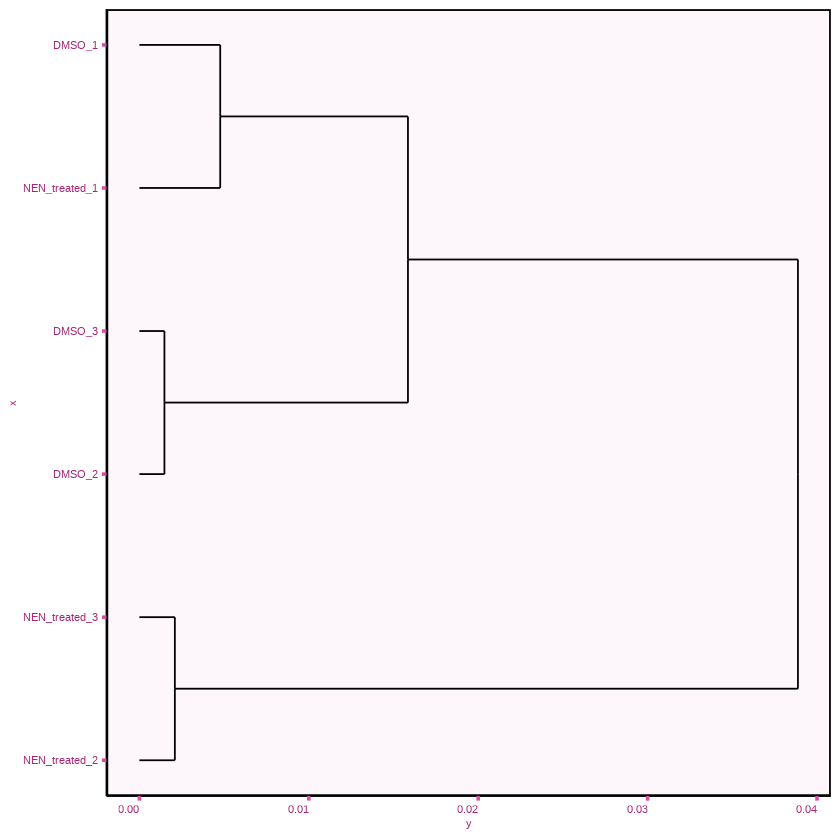

In [89]:
print(plotList)

In [90]:
chnkVec <- as.vector(NULL, mode = "character")
plotList <- list()

chnkPrefix <- "B6."
VersionPdfExt <- VersionPdfExt <- paste0(".",chnkPrefix,"V", gsub("-", "", Sys.Date()), ".pdf")


###############################################################################
## Create Clusterdendrogram                                                  ##
tag <- paste0("Clusterdendrogram")

colSelVec <- c(
    primaryAlignmentGeneID,
    dfDesign$sample.id[dfDesign$sample.id %in% names(dfTPM)]
)

colSelVec
dim(dfDesign)
names(dfTPM)


geneSelVec <- Ntop4pcaGeneSelection
geneSelVec <- geneSelVec[geneSelVec != duplicated(geneSelVec)]

dfData <- unique(dfTPM[, colSelVec])
dfData <- dfData[dfData[,primaryAlignmentGeneID] %in% geneSelVec, ]

row.names(dfData) <- dfData[,primaryAlignmentGeneID]
dfData[,primaryAlignmentGeneID] <- NULL
names(dfData) <- gsub("norm_counts_", "", names(dfData))
names(dfData) <- gsub("_TPM", "", names(dfData))





c <- cor(as.matrix(dfData), method="pearson")

d <- as.dist(1-c)
hr <- hclust(d, method = "ward.D", members=NULL)



[1] "gene_id"       "NEN_treated_2" "NEN_treated_3" "NEN_treated_1"
[5] "DMSO_2"        "DMSO_1"        "DMSO_3"

[1] 6 3

[1] "gene_id"       "DMSO_1"        "DMSO_2"        "DMSO_3"       
[5] "NEN_treated_1" "NEN_treated_2" "NEN_treated_3"

# Plot Coefficient of Variation

In [91]:
###########################################################################
## Add Coefficient of variation plot                                     ##

if (exists("dfRv")){
    tag <- "CoVar_Plot"
    
    figureCol = "DEseq2RV"
    dfDat <- unique(
        dfRv[,c( primaryAlignmentGeneID, "DEseq2RV", "CoVar")]
    )
    dfDat[["Var"]] <- dfDat[,figureCol]
    dfDat <- dfDat[order(dfDat$Var, decreasing = TRUE),]

    dfDat <- dfDat[dfDat$Var > 0, ]
    dfDat[["CoVarOrder"]] <- 1:nrow(dfDat)
    
    

    if (!exists("NtopGene")){
         NtopGene <- length(Ntop4pcaGeneSelection)
    }

    plotList[[tag]] <- ggplot2::ggplot(
    data=dfDat,
    ggplot2::aes(x=CoVarOrder, y=Var)
) + ggplot2::geom_line( ) + ggplot2::geom_vline(xintercept = NtopGene, col="red"
) +  ThemePark::theme_barbie() + ggplot2::theme(
    axis.text.y   = ggplot2::element_text(size=8),
    axis.text.x   = ggplot2::element_text(size=8),
    axis.title.y  = ggplot2::element_text(size=8),
    axis.title.x  = ggplot2::element_text(size=8),
    axis.line = ggplot2::element_line(colour = "black"),
    panel.border = ggplot2::element_rect(colour = "black", fill=NA, size=1),
    plot.title = ggplot2::element_text(hjust = 0.5, size = 12)
) + ggplot2::labs(title = paste0("Variation Seen Across all Genes")
)

    ###########################################################################
    ## Save plot to file                                                     ##
    FNbase <- paste0("CoVar", VersionPdfExt)
    FN <- paste0(figDir, FNbase)
    FNrel <- paste0("report_figures/", FNbase)

    pdf(FN)
        print(plotList[[tag]])
    dev.off()
    ##                                                                       ##
    ###########################################################################

    # link <- paste0(
    #           'An interactive version of this figure can be found ',
    #           '<a href="https://', urlString,'/',Obio@projectDetailList$project_id,'/scatterplot?x_axis=CoVarOrder&y_axis=CoVar&headline=2D+Scatterplot" target="_blank">here</a>', '. ')  
    link <- ""
    
    figLegend <- paste0(
        '**Figure ', 
        figureCount, 
        ':** ',
        ' Coefficient of variation per gene. The red line indicates the cut-off for the most variable genes in this experiment. The most variable genes are the basis for the PCA analysis and heatmap displays. Download a pdf of this figure <a href="',FNrel,'" target="_blank">here</a>. ',
     link
)
    
    

    figureCount <- figureCount + 1

    NewChnk <- paste0(
        paste0("## Coefficient of Variation \n"),
            "\n```{r CoVarPlot, results='asis', echo=F, eval=TRUE, warning=FALSE, fig.cap='",figLegend,"'}\n",
            "\n",
            "\n print(plotList[['",tag,"']])",
            "\n cat(  '\n')",
            "\n\n\n```\n"
    )

    chnkVec <- c(
        chnkVec,
        NewChnk
    )


}

## Done adding coefficient of variation                                  ##
###########################################################################
if (length(plotList) > 2){
    tabVar <- ".tabset .tabset-fade .tabset-dropdown"
} else {
    tabVar <- ".tabset .tabset-fade .tabset-pills"
}

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Ari

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Ari

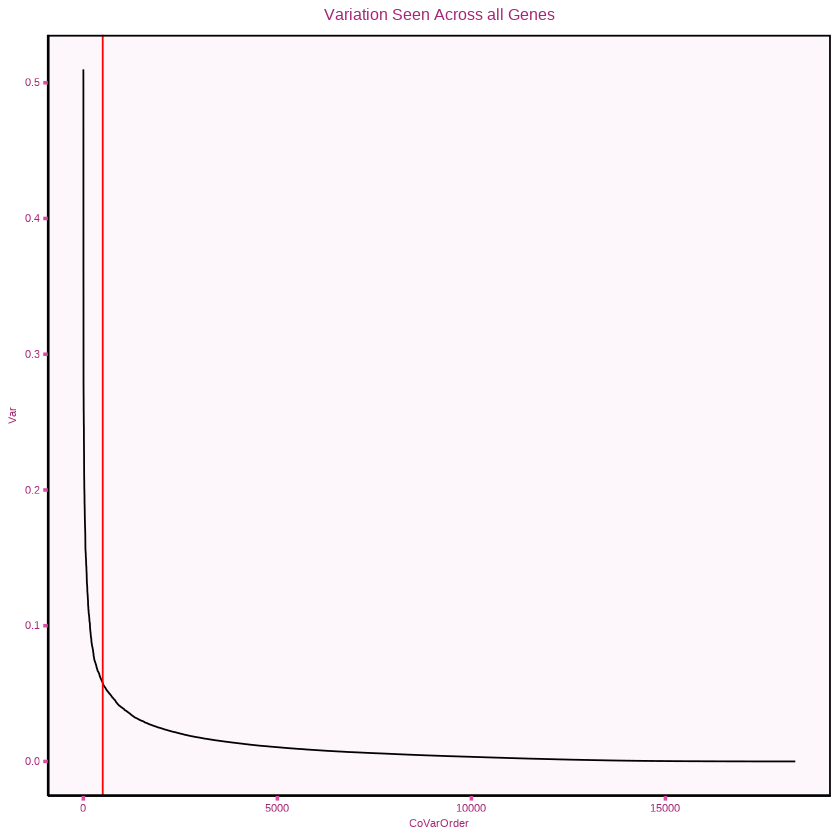

In [92]:
print(plotList[[tag]])

In [93]:
# This procedure requires the variables
# Ntop4pcaGeneSelection, project_id, primaryAlignmentGeneID, figDir, dfDesign

## Do PCA

#########################################################################
## Create DESeq2 object                                                ##

colData = unique(dfDesign[, c("sample.id", "sample.group")])
        rownames(colData) = as.vector(colData$sample.id)
        colData$sample.id <- NULL
        colnames(colData)[1] = "condition"
        colData$condition <- as.factor(colData$condition
)

dds <- DESeq2::DESeqDataSetFromMatrix(
countData = mRSEM[,row.names(colData)],
    colData   = colData,
    design    = ~ condition
)

dds <- DESeq2::estimateSizeFactors(dds)

if (length(unique(dfDesign$sample.id)) > 42) {
    rld <- DESeq2::vst(dds)
} else {
    rld <- DESeq2::rlog(dds)
}


pca = prcomp(t(SummarizedExperiment::assay(rld)[Ntop4pcaGeneSelection, ]))

PCApercentVar <- pca$sdev^2/sum(pca$sdev^2)

## Add percent variation plot ##
PercentVariation <- round(100*PCApercentVar,1)
PCdimension <- paste0("PC", 1:length(PercentVariation))
df <- data.frame(
    PercentVariation,
    PCdimension
)
df <- df[df$PercentVariation > 0,]


## Adding gene annotations ##
dfBase <- SummarizedExperiment::assay(rld)[Ntop4pcaGeneSelection, ]

dfBase <- t(dfBase)
pcaGenes = prcomp(scale(dfBase))



df.design.pca <- unique(dfDesign[,c("sample.id", "sample.group")])
df.pca = data.frame(pca$x)
df.pca[["sample.id"]] <- row.names(df.pca)

df.pca <- merge(
df.design.pca,
df.pca,
by.x = "sample.id",
by.y = "sample.id"
)

df.pca <- df.pca[order(df.pca$sample.id),]
names(df.pca) <- gsub("[.]", "_", names(df.pca))

dfPCA <- df.pca            


converting counts to integer mode



In [94]:
###############################################################################
## Add PCA plot                                                              ##


if (!exists("VersionPdfExt")){
    VersionPdfExt <- paste0(".V", gsub("-", "", Sys.Date()), ".pdf")
}



chnkVec <- as.vector(NULL, mode = "character")
plotList <- list()
tag <- "PCAvariationPerDimension"

## Use custom PCA colors if specified ##

## Just in case we still have dots instead of underscores
names(dfPCA) <- gsub("\\.", "_", names(dfPCA))
pcaSampleGroups <- unique(sort(dfPCA$sample_group))

## If sample.group colors are set use those, otherwise set default.
pos <- grep("^sample.group_color$", names(dfDesign))

if (length(pos) == 0){
    ## Create default ##
    sample.group <- unique(dfDesign$sample.group)
    sample.group_color <- sample.group
            #library(scales)
    sample.group_color = scales::hue_pal()(length(sample.group_color))
            #sample.group_color = c("#990000", "#009900")
    
    ## set sample group colors manually
    
    dfGroupColors <- unique(data.frame(sample.group, sample.group_color))
    dfDesign <- merge(dfDesign, dfGroupColors, by.x = "sample.group", "sample.group")
    
}

dfColor <- unique(
        dfDesign[,c("sample.group", "sample.group_color")]
)

if (nrow(dfColor) == length(pcaSampleGroups)){
  
    namedColors <- dfColor$sample.group_color
    names(namedColors) <- dfColor$sample.group
  
    plotList[[tag]] <- ggplot2::ggplot(
        data = dfPCA,
        ggplot2::aes(x=PC1, y=PC2, fill = sample_group)
    ) + ggplot2::geom_vline(xintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_hline(yintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_point(
        size=2,
        shape = 21
    ) + ggplot2::scale_fill_manual("Sample Groups", values = namedColors
    )
} else {
    plotList[[tag]] <- ggplot2::ggplot(
        data = dfPCA,
        ggplot2::aes(x=PC1, y=PC2, fill = sample_group)
    ) + ggplot2::geom_vline(xintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_hline(yintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_point(
        size=2,
        shape = 21
    ) 
}




if (!is.null(PCApercentVar)){
    plotList[[tag]] <- plotList[[tag]] + ggplot2::labs(
        title = "PCA Plot", 
        x = paste0("PC1 \n ",round(100* PCApercentVar[1]),"% variability explained"),
        y = paste0("PC2 \n ",round(100* PCApercentVar[2]),"% variability explained")
    )
} else {
    plotList[[tag]] <- plotList[[tag]] + ggplot2::labs(
        title = "PCA Plot", 
        x = paste0("PC1"),
        y = paste0("PC2")
    )
}

plotList[[tag]] <- plotList[[tag]] +  ThemePark::theme_barbie() + ggplot2::theme(
        axis.text.y   = ggplot2::element_text(size=8),
        axis.text.x   = ggplot2::element_text(size=8),
        axis.title.y  = ggplot2::element_text(size=12),
        axis.title.x  = ggplot2::element_text(size=12),
        axis.line = ggplot2::element_line(colour = "black"),
        panel.border = ggplot2::element_rect(colour = "black", fill=NA, size=1),
        plot.title = ggplot2::element_text(hjust = 0.5, size = 12)
)


###########################################################################
## Save plot to file                                                     ##
FNbase <- paste0("PCA12", VersionPdfExt)
FN <- paste0(figDir, FNbase)
FNrel <- paste0("report_figures/", FNbase)
FNrelT <- paste0("report_tables/", FNbase)
    
pdf(FN)
    print(plotList[[tag]])
dev.off()
##                                                                       ##
###########################################################################

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not fou

png 
  2

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Ari

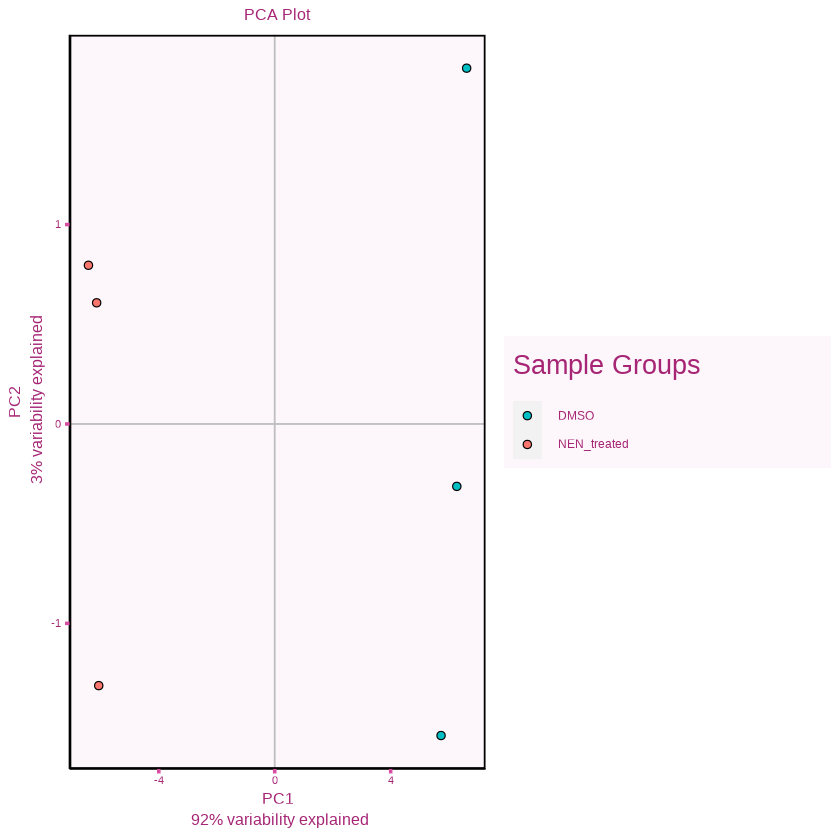

In [95]:
print(plotList[[tag]])

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_strin

png 
  2

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial' not found, will use 'sans' instead”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Ari

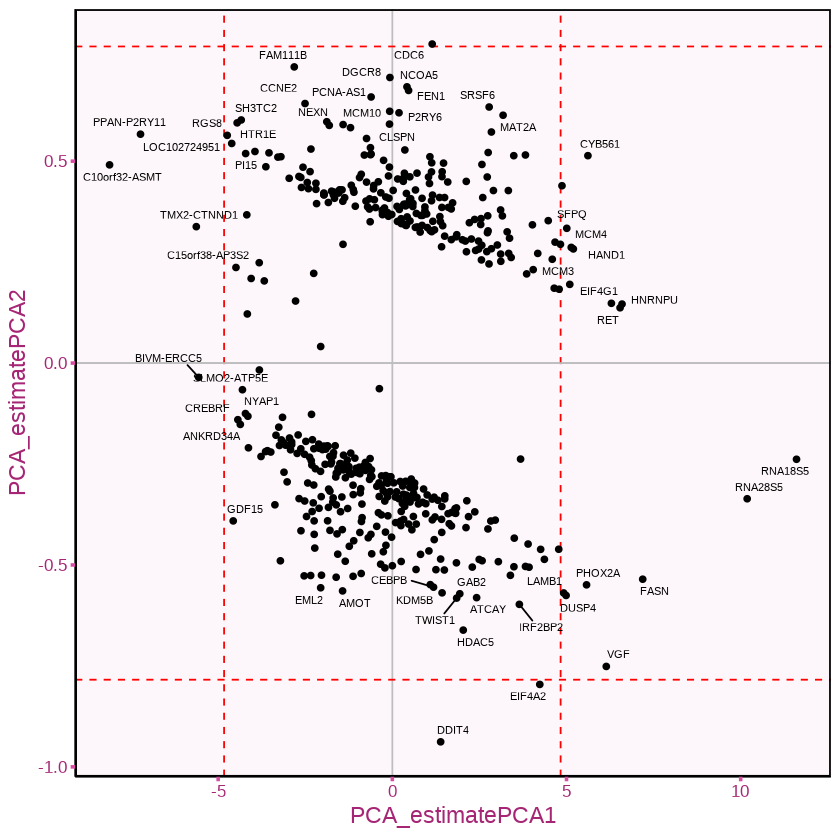

In [96]:
###############################################################################
## Get PCA Loadings                                                          ##

pcaGenes = prcomp(scale(t(dfBase)))

dfPcaGenes = data.frame(pcaGenes$x)

if (ncol(dfPcaGenes) > 10){
    dfPcaGenes <- dfPcaGenes[,1:10]
}

dfPcaGenes[[ primaryAlignmentGeneID]] <- row.names(dfPcaGenes)


dfLoad <- dfPcaGenes

dfLoad[is.na(dfLoad)] <- 0

names(dfLoad) <- gsub("^PC", "PCA_estimatePCA", names(dfLoad))

## Make Loadings Plot ##
## Plot ##
selXY <- c("PCA_estimatePCA1", "PCA_estimatePCA2", primaryAlignmentGeneID)
dfSel <- unique(dfLoad[,selXY])
#row.names(dfSel) <- dfSel$gene
dfSel[["highlight"]] <- ""
dfSel[["cat"]] <- ""
dfSel[["selX"]] <- ""
dfSel[["selY"]] <- ""
dfSel <- dfSel[order(dfSel[,selXY[1]], decreasing = FALSE), ]
dfSel[1:15, "highlight"] <- "+"
    
## Use two standard deviations for enrichment ##
twoSD <- 2*sd(dfSel[,selXY[1]])
twoSDxLine <- 2*sd(dfSel[,selXY[1]])
gSvec <- dfSel[dfSel[,selXY[1]] < -1* twoSD, primaryAlignmentGeneID]
    

dfSel <- dfSel[order(dfSel[,selXY[1]], decreasing = TRUE), ]
dfSel[1:15, "highlight"] <- "+"
gSvec <- dfSel[dfSel[,selXY[1]] >  twoSD, primaryAlignmentGeneID]
    
    
    
## Now dim 2
dfSel <- dfSel[order(dfSel[,selXY[2]], decreasing = FALSE), ]
dfSel[1:15, "highlight"] <- "+"

twoSD <- 2*sd(dfSel[,selXY[2]])
twoSDyLine <- 2*sd(dfSel[,selXY[2]])
gSvec <- dfSel[dfSel[,selXY[2]] < -1* twoSD, primaryAlignmentGeneID]




dfSel <- dfSel[order(dfSel[,selXY[2]], decreasing = TRUE), ]
dfSel[1:15, "highlight"] <- "+"
gSvec <- dfSel[dfSel[,selXY[2]] >  twoSD, primaryAlignmentGeneID]

dfSel[["label"]] <- ""
dfSel[dfSel$highlight == "+", "label"] <- dfSel[dfSel$highlight == "+", primaryAlignmentGeneID]

## Done
tag <- "PCA_Loadings"

colVec <- c("grey", "black")
names(colVec) <- c("", "Selected")

plotList[[tag]] <- ggplot2::ggplot(data=dfSel, ggplot2::aes_string(x=selXY[1],y=selXY[2], label="label")
) + ggplot2::geom_vline(xintercept = 0, color = "grey", size=0.5
) + ggplot2::geom_hline(yintercept = 0, color = "grey", size=0.5
) + ggplot2::geom_vline(xintercept = c(twoSDxLine, -1* twoSDxLine), color = "red", lty=2,size=0.5
) + ggplot2::geom_hline(yintercept = c(twoSDyLine, -1* twoSDyLine), color = "red", lty=2,size=0.5
) + ggplot2::geom_hline(yintercept = 0, color = "grey", size=0.5
) + ggplot2::geom_point(col="black") + ggplot2::scale_color_manual(values=colVec
#) + ggtitle(paste0("PCA - Cell Level")
) + ThemePark::theme_barbie(
) +  ggplot2::theme(
    #axis.text.y   = element_blank(), # element_text(size=8),
    #axis.text.x   = element_blank(), #element_text(size=8),
    #axis.title.y  = element_blank(), #element_text(size=8),
    #axis.title.x  = element_blank(), #element_text(size=8),
    axis.line = ggplot2::element_line(colour = "black"),
    legend.position = "none",
    panel.border = ggplot2::element_rect(colour = "black", fill=NA, size=1),
    #plot.title = element_text(hjust = 0.5, size = 12)
)  #+ guides(col = guide_legend(override.aes = list(shape = 16, size = legendDotSize)))

#points <-  as.vector(unique(dfSel[dfSel$highlight=="+", geneIDcolumn]))
#plotListGene[[tag]] <- LabelPoints(plot = plotListGene[[tag]], points =points, repel = TRUE, xnudge = 0, ynudge = 0)

plotList[[tag]] <-  plotList[[tag]]  + ggrepel::geom_text_repel(size = 3)


## Save to file ##
FNbase <- paste0(tag, ".", selXY[1],".", selXY[2], VersionPdfExt)
FN <- paste0(figDir, FNbase)
FNrel <- paste0("report_figures/", FNbase)

pdf(FN)
    plot(plotList[[tag]])
dev.off()

print(plotList[[tag]])

In [97]:
#DEseq2contrastTable <- Obio@databaseTable
geneIDcolumn <- primaryAlignmentGeneID

if (geneIDcolumn != "hgnc_symbol" | geneIDcolumn != "mgi_symbol"){
    geneSelCol <- "hgnc_symbol"
} else {
    geneSelCol <- geneIDColumn
}

# Variables that need to exist
# Ntop4pcaGeneSelection
# project_id 
# primaryAlignmentGeneID
# figDir 
# dfDesign 


## Make heatmap gene list
logFCselections <- names(DEseq2contrastTable)[grep("_logFC_", names(DEseq2contrastTable))]
padjSelections <- gsub("_logFC_", "_padj_", logFCselections)
dfSelections <- data.frame(logFCselections, padjSelections)
dfSelections <- dfSelections[dfSelections[,"padjSelections"] %in% names(DEseq2contrastTable),]
if (nrow(dfSelections) > 2){
    tabVar <- ".tabset .tabset-fade .tabset-dropdown"
} else {
    tabVar <- ".tabset .tabset-fade .tabset-pills"
}

## Make heatmap gene list
logFCselections <- names(DEseq2contrastTable)[grep("_logFC_", names(DEseq2contrastTable))]
padjSelections <- gsub("_logFC_", "_padj_", logFCselections)
dfSelections <- data.frame(logFCselections, padjSelections)
dfSelections <- dfSelections[dfSelections[,"padjSelections"] %in% names(DEseq2contrastTable),]

###############################################################################
## First heatmap: Most variable genes                                        ##
HMplotList <- list()
chnkVec <- as.vector(NULL, mode="character")

geneIDcolumn <- primaryAlignmentGeneID


# if (is.null(HmDisplayCatsFromDb)){
    HmDisplayCatsFromDb <- list()
# }
    
## Start with Nmost variable genes ##
if (exists("Ntop4pcaGeneSelection") && !is.null(Ntop4pcaGeneSelection) | 
    length(Ntop4pcaGeneSelection) > 3){
    dfDataTable <- dfTPM
    
    geneVec <- as.vector(unique(dfDataTable[dfDataTable[,primaryAlignmentGeneID] %in% Ntop4pcaGeneSelection,primaryAlignmentGeneID]))
} else {
    geneVec <- unique(DEseq2contrastTable[DEseq2contrastTable$logFC_cut_off == 1, geneIDcolumn])
    Ntop4pcaGeneSelection <- geneVec
}
cat.name <- paste0("Experiment_", project_id, "_",length(Ntop4pcaGeneSelection),"_most_variable_genes")
cat.description.text <- paste0(
    "In this gene set the ",
    length(geneVec),
    " most variable genes."
)
HmDisplayCatsFromDb[[cat.name]] <- list(
      "cat_type" = paste0("temp_", project_id),
      "data_source" = "Most variable heatmap genes" ,
      "cat.description.text" = cat.description.text,
      "geneVec" = geneVec,
      "catID" = NULL,
      "comparisonID" = NULL
)
###########################################################################
## Make one heatmap per comparison                                       ##
    
numextract <- function(string){ 
    stringr::str_extract(string, "contrast_\\-*\\d+\\.*\\d*_")
} 

dfSelections[["designColumn"]] <- sapply(dfSelections$padjSelections, function(x) unlist(strsplit(x, "padj_"))[2]) 

## Get design column from model file ##
designColNames <- sapply(dfSelections$padjSelections, function(x) unlist(strsplit(x, "padj_"))[2])

modelComp <- as.vector(dfModel$comparison)
designColNames[!(designColNames %in% modelComp)] <- ""

dfModelSel <- dfModel[dfModel$comparison %in% designColNames,]

dfSelections[["designColumn"]] <- ""

    if (nrow(dfModelSel) > 0){
    ## replace all entries found in dfModel to comparisonID
    for (i in 1:nrow(dfModelSel)){
        designColNames <- gsub(paste0("^", as.vector(dfModel[i, "comparison"]), "$"), as.vector(dfModel[i, "comparisonID"]),designColNames )
    }
    
    dfSelections[["designColumn"]]  <-  designColNames 
} 



for (k in 1:nrow(dfSelections)){
    dfDataTable <- DEseq2contrastTable
    padjCutOff <- 0.05
        
    geneVec <- as.vector(
        unique(
            dfDataTable[dfDataTable[,as.vector(dfSelections$padjSelections[k])] < 0.05 & dfDataTable[,as.vector(dfSelections$logFCselections[k])] != 0,geneIDcolumn]
            )
    )
        
    if (length(geneVec) > 1500){
        padjCutOff <- 0.01
        
        geneVec <- as.vector(
            unique(
                dfDataTable[dfDataTable[,as.vector(dfSelections$padjSelections[k])] < 0.01 & 
                                    dfDataTable[,as.vector(dfSelections$logFCselections[k])] != 0,geneIDcolumn
                ]
            )
        )
    }
        
    ## Insert gene set into database ##
    cat.name <- paste0(
        "Experiment_",project_id, "_",dfSelections$padjSelections[k],"_smaller_than_", gsub("[.]", "_", padjCutOff)
    )
    
    cat.description.text <- paste0(
        "In this gene set the genes that exhibited an adjusted p value of less than ", 
        padjCutOff, 
        " in the differential gene expression comparsion ", 
        as.vector(dfSelections$logFCselections[k]),
        ". "
      )
        
      comparisonID <- as.vector(dfSelections[k, "designColumn"])
      if (comparisonID == ""){
          comparisonID <- NULL
      }
    
      HmDisplayCatsFromDb[[cat.name]] <- list(
          "cat_type" = paste0("temp_", project_id),
          "data_source" = "From experiment" ,
          "cat.description.text" = cat.description.text,
          "geneVec" = geneVec,
          "catID" = NULL,
          "comparisonID" = comparisonID
      )
            
}
## Done with making heatmap list                                         ##
###########################################################################



In [98]:
names(HmDisplayCatsFromDb)

[1] "Experiment_RNA_Seq_NEM_Analysis_001_500_most_variable_genes"                              
[2] "Experiment_RNA_Seq_NEM_Analysis_001_contrast_1_padj_NEN_treated_vs_DMSO_smaller_than_0_01"

In [99]:
###############################################################################
## Reorder Obio@parameterList$HmDisplayCatsFromDb so that 500 var is on top  ##

if (!exists("HmDisplayCatsFromDb")) {
    HmDisplayCatsFromDb <- list()
}

pos <- grep("most_variable_genes", names(HmDisplayCatsFromDb))
if (length(pos) > 0){
  pos <- pos[1]
  newOrder <- c(
    names(HmDisplayCatsFromDb)[pos],
    names(HmDisplayCatsFromDb)[-pos]
  )
  HmDisplayCatsFromDb <- HmDisplayCatsFromDb[newOrder]
}
##                                                                           ##


In [100]:
## Create Heatmaps ##
###############################################################################
## Reorder Obio@parameterList$HmDisplayCatsFromDb so that 500 var is on top  ##
pos <- grep("most_variable_genes", names(HmDisplayCatsFromDb))
if (length(pos) > 0){
  pos <- pos[1]
  newOrder <- c(
    names(HmDisplayCatsFromDb)[pos],
    names(HmDisplayCatsFromDb)[-pos]
  )
  HmDisplayCatsFromDb <- HmDisplayCatsFromDb[newOrder]
}
##                                                                           ##
###############################################################################

In [101]:
#######################################################################
## Add custon gene set(s) for heatmap plotting

# chatGPT query: make me a gene list (offical hgnc symbols) of all human g-protein coupled receptors

# Load the required package
library(biomaRt)

# Connect to the Ensembl database
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

# Retrieve the GPCR gene list
gpcr_genes <- getBM(attributes = c("hgnc_symbol"), filters = "go", values = "GO:0004930", mart = ensembl)

# Print the gene list
geneVec <- as.vector(sort(gpcr_genes[,1]))

geneVec

HmDisplayCatsFromDb[["GPCR_genes"]] <- list(
          "cat_type" = paste0("temp_", project_id),
          "data_source" = "From experiment" ,
          "cat.description.text" = "Custom gene category",
          "geneVec" = geneVec,
          "catID" = NULL,
          "comparisonID" = NULL
      )

                     




[1] "ACKR1"           "ACKR2"           "ACKR3"           "ACKR4"          
  [5] "ADCYAP1R1"       "ADGRA1"          "ADGRA2"          "ADGRA3"         
  [9] "ADGRB1"          "ADGRB2"          "ADGRB3"          "ADGRD1"         
 [13] "ADGRD2"          "ADGRE1"          "ADGRE2"          "ADGRE3"         
 [17] "ADGRE5"          "ADGRF1"          "ADGRF3"          "ADGRF4"         
 [21] "ADGRF5"          "ADGRG1"          "ADGRG2"          "ADGRG3"         
 [25] "ADGRG4"          "ADGRG5"          "ADGRG6"          "ADGRG7"         
 [29] "ADGRL1"          "ADGRL2"          "ADGRL3"          "ADGRL4"         
 [33] "ADGRV1"          "ADORA1"          "ADORA2A"         "ADORA2B"        
 [37] "ADORA3"          "ADRA1A"          "ADRA1B"          "ADRA1D"         
 [41] "ADRA2A"          "ADRA2B"          "ADRA2C"          "ADRB1"          
 [45] "ADRB2"           "ADRB3"           "AGTR1"           "AGTR2"          
 [49] "APLNR"           "AR"              "AVPR1A"          "AVPR1B"         
 [53] "AVPR2"           "BDKRB1"          "BDKRB2"          "BRS3"           
 [57] "C3AR1"           "C5AR1"           "C5AR2"           "CALCR"          
 [61] "CALCRL"          "CASR"            "CCKAR"           "CCKBR"          
 [65] "CCR1"            "CCR10"           "CCR2"            "CCR3"           
 [69] "CCR4"            "CCR5"            "CCR6"            "CCR7"           
 [73] "CCR8"            "CCR9"            "CCRL2"           "CELSR1"         
 [77] "CELSR2"          "CELSR3"          "CHML"            "CHRM1"          
 [81] "CHRM2"           "CHRM3"           "CHRM4"           "CHRM5"          
 [85] "CMKLR1"          "CMKLR2"          "CNR1"            "CNR2"           
 [89] "CRHR1"           "CRHR2"           "CX3CR1"          "CXCR1"          
 [93] "CXCR2"           "CXCR3"           "CXCR4"           "CXCR5"          
 [97] "CXCR6"           "CYSLTR1"         "CYSLTR2"         "DRD1"           
[101] "DRD2"            "DRD3"            "DRD4"            "DRD5"           
[105] "EDNRA"           "EDNRB"           "F2R"             "F2RL1"          
[109] "F2RL2"           "F2RL3"           "FFAR1"           "FFAR2"          
[113] "FFAR3"           "FFAR4"           "FPR1"            "FPR2"           
[117] "FPR3"            "FSHR"            "FZD1"            "FZD10"          
[121] "FZD2"            "FZD3"            "FZD4"            "FZD5"           
[125] "FZD6"            "FZD7"            "FZD8"            "FZD9"           
[129] "GABBR1"          "GABBR2"          "GALR1"           "GALR2"          
[133] "GALR3"           "GCGR"            "GHRHR"           "GHSR"           
[137] "GIPR"            "GLP1R"           "GLP2R"           "GNRHR"          
[141] "GPBAR1"          "GPER1"           "GPR101"          "GPR119"         
[145] "GPR12"           "GPR132"          "GPR135"          "GPR139"         
[149] "GPR141"          "GPR142"          "GPR143"          "GPR146"         
[153] "GPR148"          "GPR149"          "GPR15"           "GPR150"         
[157] "GPR151"          "GPR152"          "GPR153"          "GPR156"         
[161] "GPR157"          "GPR158"          "GPR160"          "GPR161"         
[165] "GPR162"          "GPR17"           "GPR171"          "GPR173"         
[169] "GPR174"          "GPR176"          "GPR179"          "GPR18"          
[173] "GPR182"          "GPR183"          "GPR19"           "GPR20"          
[177] "GPR21"           "GPR22"           "GPR25"           "GPR26"          
[181] "GPR27"           "GPR3"            "GPR31"           "GPR32"          
[185] "GPR33"           "GPR34"           "GPR35"           "GPR37"          
[189] "GPR37L1"         "GPR39"           "GPR4"            "GPR42"          
[193] "GPR45"           "GPR50"           "GPR52"           "GPR55"          
[197] "GPR6"            "GPR61"           "GPR62"           "GPR63"          
[201] "GPR65"           "GPR68"           "GPR75"           "GPR78"          
[205] "GPR82"           

In [102]:
## Make a list of all differentially regulated GPCR genes
names(HmDisplayCatsFromDb)
diffRegGenes <- HmDisplayCatsFromDb[["Experiment_RNA_Seq_Integration_001_contrast_1_padj_NonResponder_vs_Responder_smaller_than_0_05"]]$geneVec

geneVec <- diffRegGenes[diffRegGenes %in% HmDisplayCatsFromDb[["GPCR_genes"]]$gene]

if (length(geneVec) > 0){
    HmDisplayCatsFromDb[["diff_cont_1_GPCR_genes"]] <- list(
          "cat_type" = paste0("temp_", project_id),
          "data_source" = "From experiment" ,
          "cat.description.text" = "Custom gene category",
          "geneVec" = geneVec,
          "catID" = NULL,
          "comparisonID" = NULL
      )

} else {
    geneVec <- HmDisplayCatsFromDb[["GPCR_genes"]]
    HmDisplayCatsFromDb[["GPCR_genes"]] <- list(
          "cat_type" = paste0("temp_", project_id),
          "data_source" = "From experiment" ,
          "cat.description.text" = "Custom gene category",
          "geneVec" = geneVec,
          "catID" = NULL,
          "comparisonID" = NULL
      )
    
}

names(HmDisplayCatsFromDb)

[1] "Experiment_RNA_Seq_NEM_Analysis_001_500_most_variable_genes"                              
[2] "Experiment_RNA_Seq_NEM_Analysis_001_contrast_1_padj_NEN_treated_vs_DMSO_smaller_than_0_01"
[3] "GPCR_genes"

[1] "Experiment_RNA_Seq_NEM_Analysis_001_500_most_variable_genes"                              
[2] "Experiment_RNA_Seq_NEM_Analysis_001_contrast_1_padj_NEN_treated_vs_DMSO_smaller_than_0_01"
[3] "GPCR_genes"

In [103]:
## Begin heatmap plotting loop ##
if (!exists("HMplotList")){
    HMplotList <- list()
}

for (k in 1:length(HmDisplayCatsFromDb)){
    
    ## Select samples to display ##
    if (!is.null(HmDisplayCatsFromDb[[k]]$comparisonID)){
        dfSel <- unique(dfDesign[,c("sample.id", HmDisplayCatsFromDb[[k]]$comparisonID)])
        dfSel <- dfSel[dfSel[,HmDisplayCatsFromDb[[k]]$comparisonID] != "",]
        
        if (nrow(dfSel) > 1){
            sampleSelection <- paste0(unique(dfSel$sample.id))    
        } else {
            sampleSelection <- paste0(unique(dfDesign$sample.id))
        }
        
    } else {
        sampleSelection <- paste0(unique(dfDesign$sample.id))
    }
  
    ## Check ##
     
    sampleSelection <- unique(names(dfData)[unlist(sapply(paste0("^", sampleSelection, "$"), function(x) grep(x, names(dfData))))])
    selVec <- c(geneIDcolumn, sampleSelection )
    ## Get gene selection 
    geneSel <- HmDisplayCatsFromDb[[k]]$geneVec
    
    geneSel <- unique(geneSel)
    geneSel <- geneSel[geneSel != ""]
    
    if (length(geneSel) > 2){
        dfDataTable <- dfTPM
        dfDataTable <- unique(dfDataTable[dfDataTable[, geneIDcolumn] %in% geneSel, selVec])
        
        dfHmBase <- unique(dfDataTable[,selVec])
        
        while (sum(duplicated(dfHmBase[, geneIDcolumn])) > 0){
            dfHmBase[duplicated(dfHmBase[, geneIDcolumn]), geneIDcolumn] <- paste0(
                dfHmBase[duplicated(dfHmBase[, geneIDcolumn]), 
                geneIDcolumn], "_", i
            )
            i=i+1
        }
        
        row.names(dfHmBase) <- dfHmBase[, geneIDcolumn]
        dfHmBase[, geneIDcolumn] <- NULL
        
        ## calculate row-means ##
        rowMeans <- apply(
            dfHmBase,
            1,
            function(x) mean(x)
        )
            
        rowMeans[rowMeans ==0] <- 0.001
            
        hmMax <- 4
        for (i in 1:ncol(dfHmBase)){
            dfHmBase[,i] <- log2(dfHmBase[,i] / rowMeans)
        }
            
        dfHmBase[dfHmBase > hmMax] <- hmMax
        dfHmBase[dfHmBase < -1*hmMax] <- -1*hmMax
            
            
        names(dfHmBase) <- gsub("norm_counts_", "", names(dfHmBase))
        names(dfHmBase) <- gsub("_TPM", "", names(dfHmBase))
            
        mHmBase <- data.matrix(dfHmBase)
            
        if ( nrow(mHmBase) < 51){
            showRowNames <- TRUE
        } else {
            showRowNames <- FALSE
        }
        
        ## Create heatmap plot ##
        #library(ComplexHeatmap)
       
        f1 = circlize::colorRamp2(seq(-4, 4, length = 3), c("#3060cf", "#fffbbc","#c4463a"))    
    
        anno <- as.data.frame(colnames(mHmBase))
        colnames(anno) <- "Sample"
        anno$Group <- sapply(as.vector(anno[,1]), function(x) paste0(unlist(strsplit(x, "_"))[1], "_",unlist(strsplit(x, "_"))[2]))
        
        ## Color sample groups in line with the designated sample group color ##
        #######################################################################
        ## Add sample group colors if needed
        pos <- grep("sample.group_color", names(dfDesign))
        
        if (length(pos) == 0){
            sample.group <- unique(dfDesign$sample.group)
            sample.group_color <- sample.group
            #library(scales)
            sample.group_color = scales::hue_pal()(length(sample.group_color))
            #sample.group_color = c("#990000", "#009900")
            dfGroupColors <- unique(data.frame(sample.group, sample.group_color))
            dfDesign <- merge(dfDesign, dfGroupColors, by.x = "sample.group", "sample.group")
            if (exists("Obio")){
                Obio@dfDesign <- dfDesign
            }
            
        }
        
        
        
        #library(scales)
        #hue_pal()(2)
        df <- unique(data.frame(dfDesign[,c("sample.id", "sample.group", "sample.group_color")]))
        df <- df[df$sample.id %in% colnames(mHmBase),]
        df2 <- data.frame(df[,"sample.group"])
        names(df2) <- "Group"
        
                
        GroupVec <- as.vector(unique(df$sample.group_color))
        names(GroupVec) <- as.vector(unique(df$sample.group))
        
        
        
        #df2 <- unique(data.frame(Obio@dfDesign[,c("sample.id","sample.group", "sample.group_color")]))
        #df2 <- data.frame(df2[,c("sample.group")])
        
        
        
        ha = ComplexHeatmap::HeatmapAnnotation(df = df2, col = list(Group = GroupVec))
    
        ComplexHeatmap::ht_opt(
            legend_border = "black",
            heatmap_border = TRUE,
            annotation_border = TRUE
        )
        
        hmTitle <- unlist(strsplit(names(HmDisplayCatsFromDb)[k], "_padj_"))
        if (length(hmTitle) == 2){
            hmTitle <- paste0("padj_", hmTitle[2])
        } else {
            hmTitle <- names(HmDisplayCatsFromDb)[k]
        }
        
        HMplotList[[names(HmDisplayCatsFromDb)[k]]] = ComplexHeatmap::Heatmap(
            mHmBase,
            column_title = gsub(
                    "_", 
                    " ", 
                    hmTitle
            ),
            name = paste0("HM_", k), 
            #row_km = 5,
            col = f1,
            column_split = factor(df2$Group, levels = unique(df2$Group)),
           
            show_column_names = T,
            show_row_names = showRowNames,
            border = TRUE,

         
            #Dendrogram configurations: columns
            clustering_distance_columns="euclidean",
            clustering_method_columns="complete",
            column_dend_height=grid::unit(10,"mm"),
            
            #Dendrogram configurations: rows
            clustering_distance_rows="euclidean",
            clustering_method_rows="complete",
            row_dend_width=grid::unit(10,"mm"),
            top_annotation = ha,
            show_heatmap_legend = TRUE
            #row_title = NULL,
            #show_row_dend = FALSE
        ) 
        
    ComplexHeatmap::ht_opt(RESET = TRUE)
        
    if (! is.null(HmDisplayCatsFromDb[[k]]$cat_id)){
        link <- paste0(
            'An interactive version of this heatmap with an option for further filtering can be found <a href="',
            "https://biologic.crick.ac.uk/",
            project_id,"/category-view/",
            HmDisplayCatsFromDb[[k]]$cat_id,'" target="_blank">here</a>.'
        )
        
    } else {
        link <- ""
    }
    
    ###########################################################################
    ## Save plot to file                                                     ##
    FNbase <- paste0("Heatmap.", names(HmDisplayCatsFromDb)[k],VersionPdfExt)
    FN <- paste0(figDir, FNbase)
    FNrel <- paste0("report_figures/", FNbase)
    
    pdf(FN)
        print(HMplotList[[names(HmDisplayCatsFromDb)[k]]])
    dev.off()
    ##                                                                       ##
    ###########################################################################
    
    figCap <- paste0(
    '**Figure ',
    figureCount,
    ':** Heatmap showing the gene category ', gsub('_', ' ', names(HmDisplayCatsFromDb)[k]), '. ',
        'Download a pdf of this figure <a href="',FNrel,'" target="_blank">here</a>. ',
        link
    )
    
    figureCount <- figureCount + 1 
    
    NewChnk <- paste0(
            "## HM_", names(HmDisplayCatsFromDb)[k],
            "\n```{r, results='asis', echo=F, eval=TRUE, warning=FALSE, fig.cap='",figCap,"'}\n",
            "\n",
            "\n print(HMplotList[['",names(HmDisplayCatsFromDb)[k],"']])",
            "\n cat(  '\n')",
            "\n\n\n```\n"   
    )
    
    chnkVec <- c(
        chnkVec,
        NewChnk
    )
    
    } ## End making heatmap 
    
## Done making heatmaps                                                      ##
###############################################################################
}
## End heatmap plotting loop
## Done                                                                      ##
###############################################################################

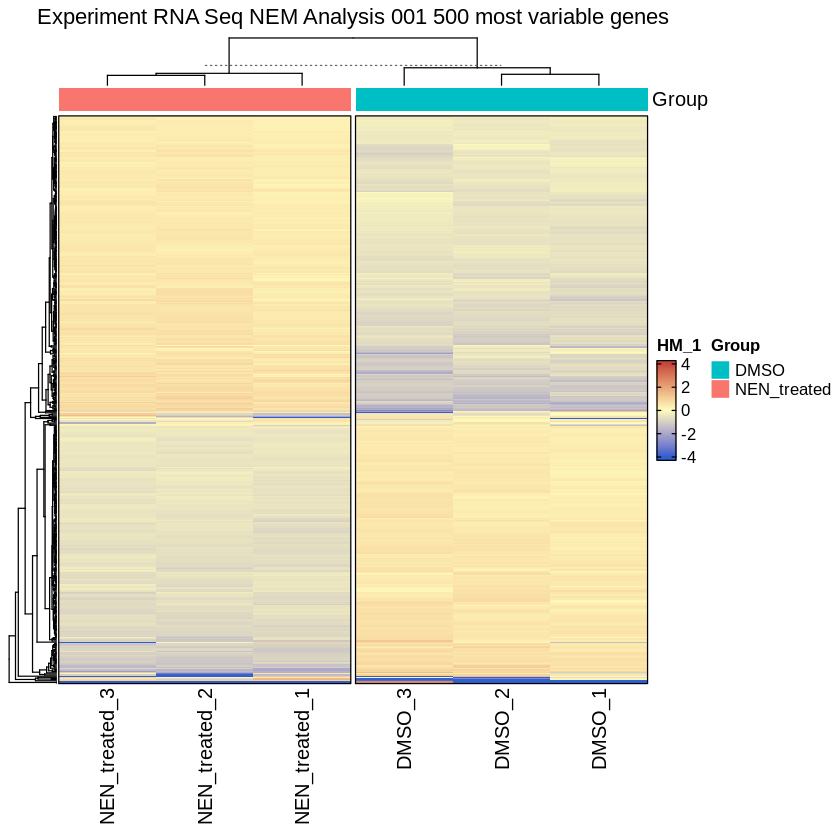

In [104]:
## Make heatmap gene list

print(HMplotList[[1]])


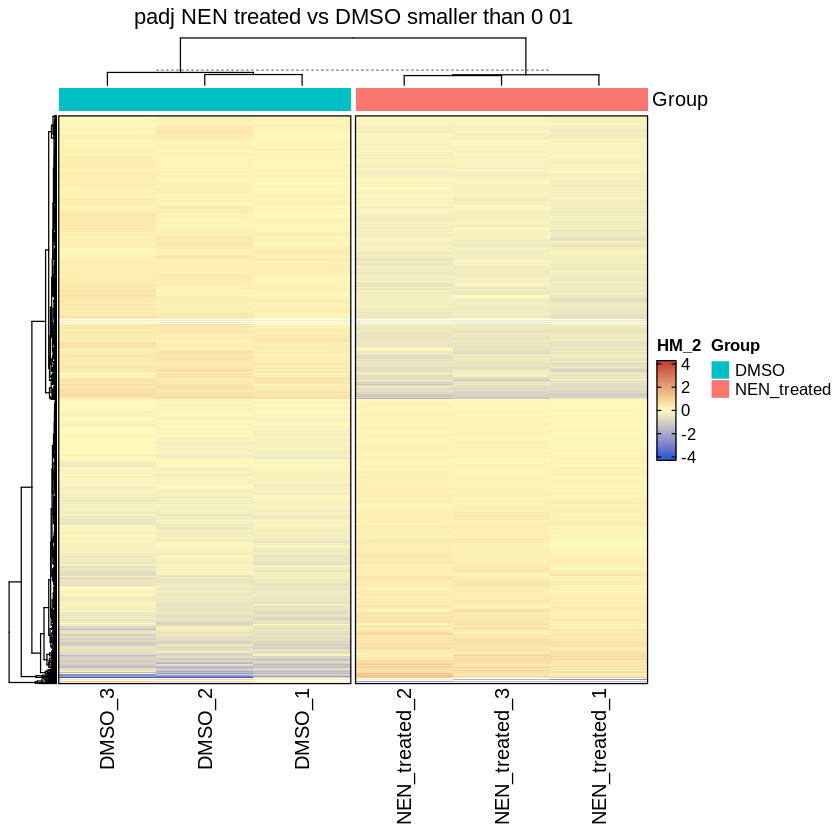

In [105]:
## Make heatmap gene list
print(HMplotList[[2]])

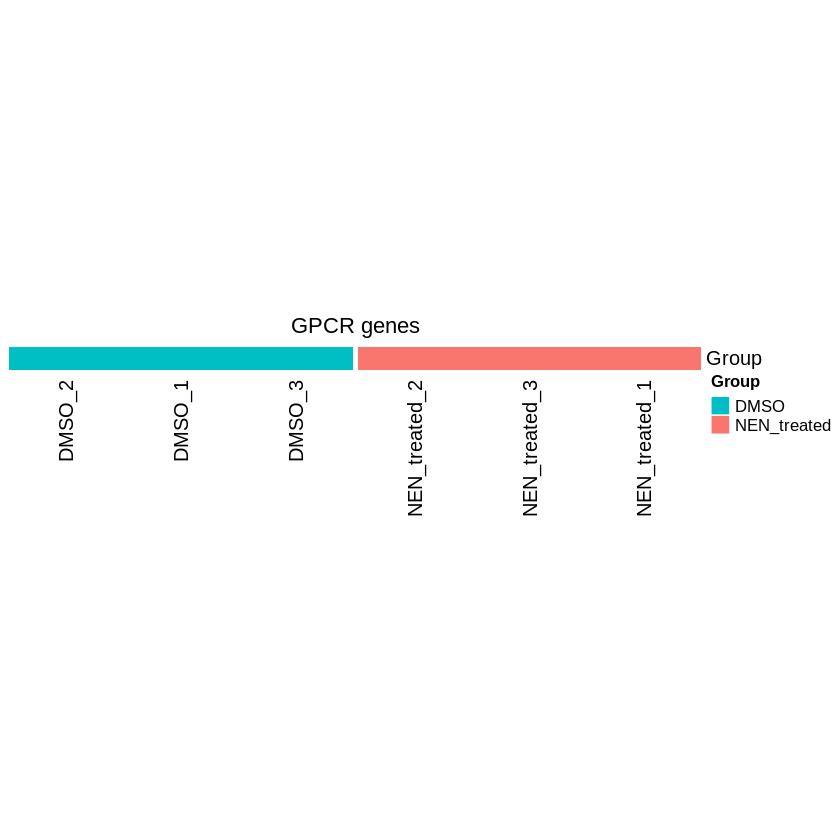

In [106]:
## Make heatmap gene list
print(HMplotList[[3]])

In [107]:
## Make heatmap gene list
print(HMplotList[[4]])

ERROR: Error in HMplotList[[4]]: subscript out of bounds


In [ ]:
dfMainData <- DEseq2contrastTable

head(dfMainData)

if (!exists("sdCutOff")){
  sdCutOff <- 2  
}

chnkVec <- as.vector(NULL, mode = "character")

MAplotList <- list()
VplotList <- list()

## Create dfMAplots ##
contrastSel <- c(
  names(dfMainData)[grep("contrast_[A-Z]?[0-9]{1,2}", names(dfMainData))],
  names(dfMainData)[grep("contrast_D[A-Z]?[0-9]{1,2}", names(dfMainData))]
)
MAselVec <- c(
    contrastSel[grep("lg2BaseMean", contrastSel)],
    contrastSel[grep("logFC", contrastSel)]
)

VolcanoSelVec <- c(
    contrastSel[grep("logFC", contrastSel)],
    contrastSel[grep("lg10p", contrastSel)]
)

contrastVec <- as.vector(sapply(
    contrastSel[grep("logFC", contrastSel)],
    function(x) unlist(strsplit(x, "logFC_"))[2]
))



In [ ]:
###############################################################################
## Make MA plot function                                                     ##


makeMAplot <- function(
    dfPlotData,
    geneIDcolumn,
    topNgenes = 5,
    dotsize = 1,
    legendDotSize = 5,
    sdCutOff = 1
){
    headline <- names(dfPlotData)[grep("logFC", names(dfPlotData))]
    headline <- unlist(strsplit(headline, "logFC_"))[2]
    
    names(dfPlotData) <- gsub("contrast_[0-9]{1,2}_", "", names(dfPlotData))
    
    logFCcolName <- names(dfPlotData)[grep("logFC", names(dfPlotData))]
    padjColName <- names(dfPlotData)[grep("padj", names(dfPlotData))]

    dfPlotData <- dfPlotData[!is.na(dfPlotData[, padjColName]),]
    
    lg2BaseMeanColName <- names(dfPlotData)[grep("lg2BaseMean", names(dfPlotData))]
    
    
## Now let's get these data columns out of the main data table.
    dfPlotData <- dfPlotData[dfPlotData[,lg2BaseMeanColName] > 0, ]
    
    
## For plotting we are using the R-package ggplot. This is a widely used, comprehensive package to make beautiful plots. More information on that here: https://ggplot2.tidyverse.org/
    
    library(ggplot2)
    
    ## Let's add an example for custom coloring here. We are going to highlight the most variable genes in this scatterplot. To do that, we need to add a color column to the plot data dataframe.
    
    ## Now let's color by significantly up-regulated genes in red, and significantly downregulated genes in blue
    
    dfPlotData[["color"]] <- "NS"
    dfPlotData[dfPlotData[, logFCcolName] > 0 & dfPlotData[, padjColName] < 0.05, "color"] <-  "Up"
    
    dfPlotData[dfPlotData[, logFCcolName] < 0 & dfPlotData[, padjColName] < 0.05, "color"] <-  "Down"
    
    ## Re-order dfPlotData for better results
    
    ## Let's have a look at the color vector
    
    
    colorVec <- c("blue", "red","black")
    
    names(colorVec) <- c("Down", "Up", "NS")
    
    
    ## And here is the resulting color vector
    colorVec <- colorVec[names(colorVec) %in% dfPlotData$color]
    
    dfPlotData$color <- factor(dfPlotData$color, levels = names(colorVec))
    dfPlotData <- dfPlotData[order(dfPlotData$color, decreasing = F), ]
    
    ## Now let's also add a label for the 10 most significantly up- and down-regulated genes.This number can be changed in the variable Nsel. Here we use the R package ggrepel.
    
    library(ggrepel)
    
    ## Let's order the data frame by log-fold change
    dfPlotData <- dfPlotData[order(dfPlotData[,logFCcolName], decreasing = T), ]
    topGenes <- as.vector(dfPlotData[1:topNgenes,geneIDcolumn])
    
    dfPlotData <- dfPlotData[order(dfPlotData[,logFCcolName], decreasing = F), ]
    bottomGenes <- as.vector(dfPlotData[1:topNgenes,geneIDcolumn])
    
    dfPlotData[["label"]] <- ""
    dfPlotData[dfPlotData[,geneIDcolumn] %in% c(topGenes, bottomGenes), "label"] <- dfPlotData[dfPlotData[,geneIDcolumn] %in% c(topGenes, bottomGenes), geneIDcolumn]
    
    yScaleMax <- max(abs(dfPlotData[,logFCcolName]))
    
    lgFCsel <- sdCutOff * sd(dfPlotData[, logFCcolName])
    ## Now let's first make the MA-plot without lables
    
    plotNoLabels <- ggplot(
        data = dfPlotData, 
        aes_string(x=lg2BaseMeanColName, y=logFCcolName, color = "color", label = "label")
    ) + geom_hline(yintercept = 0, color = "black", size=0.5
    ) + geom_hline(yintercept = c(-1*lgFCsel,lgFCsel), color = "grey", size=0.5, linetype = 2               
    ) + geom_point( shape=16, size = dotsize
    ) + scale_colour_manual(name = "Significant" ,values = colorVec
    ) + theme_bw(
    )  +  theme(
        axis.text.y   = element_text(size=8),
        axis.text.x   = element_text(size=8),
        axis.title.y  = element_text(size=8),
        axis.title.x  = element_text(size=8),
        axis.line = element_line(colour = "black"),
        panel.border = element_rect(colour = "black", fill=NA, size=1),
        plot.title = element_text(hjust = 0.5, size = 12)
    ) + ylim(-1*yScaleMax, yScaleMax
    ) + ggtitle(paste0("MA-Plot ", contrastVec[i])            
    ) + xlab(gsub("_", " ", logFCcolName)
    ) + ylab(gsub("_", " ", logFCcolName)            
    ) + guides(col = guide_legend(override.aes = list(shape = 16, size = legendDotSize))
    ) 
         
    
    ## And now let's add the labels:
    plotWithLabels <- plotNoLabels + geom_text_repel(size = 3)
    
    return(plotWithLabels)  
}

## End Make MA plot function                                                 ##
###############################################################################



In [ ]:
###############################################################################
## Make Volcanoplot                                                          ##
makeVolcanoPlot <- function(
    dfPlotData,
    geneIDcolumn,
    topNgenes = 5,
    dotsize = 1,
    legendDotSize = 5,
    sdCutOff = 1
){
    headline <- names(dfPlotData)[grep("logFC", names(dfPlotData))]
    headline <- unlist(strsplit(headline, "logFC_"))[2]
    
    names(dfPlotData) <- gsub("contrast_[0-9]{1,2}_", "", names(dfPlotData))
    
    logFCcolName <- names(dfPlotData)[grep("logFC", names(dfPlotData))]
    lg10pColName <- names(dfPlotData)[grep("lg10p", names(dfPlotData))]
    padjColName <- names(dfPlotData)[grep("padj", names(dfPlotData))]
    
    ## Now let's get these data columns out of the main data table.
    dfPlotData <- dfPlotData[dfPlotData[,logFCcolName] != 0, ]
    
    ## Determine logFC cut-off for the Volcano Plot ##
    lgFCsel <- sdCutOff * sd(dfPlotData[, logFCcolName])
    
    dfPlotData[["color"]] <- "NS"
    dfPlotData[dfPlotData[, logFCcolName] > lgFCsel & dfPlotData[, padjColName] < 0.05, "color"] <-  "Up"
    
    dfPlotData[dfPlotData[, logFCcolName] < -1*lgFCsel & dfPlotData[, padjColName] < 0.05, "color"] <-  "Down"
    
    ## Re-order dfPlotData for better results
    
    ## Let's have a look at the color vector
    
    
    colorVec <- c("blue", "red","black")
    
    names(colorVec) <- c("Down", "Up", "NS")
    
    
    ## And here is the resulting color vector
    colorVec <- colorVec[names(colorVec) %in% dfPlotData$color]
    
    dfPlotData$color <- factor(dfPlotData$color, levels = names(colorVec))
    dfPlotData <- dfPlotData[order(dfPlotData$color, decreasing = F), ]
    
    ## And here is the resulting color vector
    colorVec <- colorVec[names(colorVec) %in% dfPlotData$color]
    
    dfPlotData$color <- factor(dfPlotData$color, levels = names(colorVec))
    dfPlotData <- dfPlotData[order(dfPlotData$color, decreasing = F), ]
    
    ## Now let's also add a label for the 10 most significantly up- and down-regulated genes.This number can be changed in the variable Nsel. Here we use the R package ggrepel.
    
    library(ggrepel)
    
    ## Let's order the data frame by log-fold change
    dfPlotData <- dfPlotData[order(dfPlotData[,logFCcolName], decreasing = T), ]
    topGenes <- as.vector(dfPlotData[1:topNgenes,geneIDcolumn])
    
    dfPlotData <- dfPlotData[order(dfPlotData[,logFCcolName], decreasing = F), ]
    bottomGenes <- as.vector(dfPlotData[1:topNgenes,geneIDcolumn])
    
    dfPlotData[["label"]] <- ""
    dfPlotData[dfPlotData[,geneIDcolumn] %in% c(topGenes, bottomGenes), "label"] <- dfPlotData[dfPlotData[,geneIDcolumn] %in% c(topGenes, bottomGenes), geneIDcolumn]
    
xMaxVal <- max(abs(dfPlotData[,logFCcolName]))
    
pVolcano <- ggplot(
        data = dfPlotData, 
        aes_string(x=logFCcolName, y=lg10pColName, color = "color",label = "label")
    ) + geom_hline(yintercept = 0, color = "black", size=0.5
    ) + geom_hline(yintercept = -1*log10(0.05), color = "grey", size=0.5, linetype = 2
    ) + geom_vline(xintercept = 0, color = "black", size=0.5
    ) + geom_vline(xintercept = c(-1*lgFCsel,lgFCsel), color = "grey", size=0.5, linetype = 2      ) + geom_point( shape=16, size = dotsize
    ) + scale_colour_manual(name = "Variability" ,values = colorVec
    
    ) + theme_bw(
    )  +  theme(
        axis.text.y   = element_text(size=8),
        axis.text.x   = element_text(size=8),
        axis.title.y  = element_text(size=8),
        axis.title.x  = element_text(size=8),
        axis.line = element_line(colour = "black"),
        panel.border = element_rect(colour = "black", fill=NA, size=1),
        plot.title = element_text(hjust = 0.5, size = 12)
    ) + xlim(-1*xMaxVal,xMaxVal
    ) + ggtitle(paste0("Volcano Plot ", contrastVec[i]) 
    ) + xlab(gsub("_", " ", logFCcolName)
    ) + ylab(gsub("_", " ", lg10pColName)            
    ) + guides(col = guide_legend(override.aes = list(shape = 16, size = legendDotSize))
    ) 

    plotVolcanoWithLabels <- pVolcano + geom_text_repel(size = 3)

return(plotVolcanoWithLabels)
}
## Done Volcanoplot                                                          ##
###############################################################################



In [ ]:
contrastVec
for (i in 1:length(contrastVec)){
    ## Make MA-plot ##
    contrastVec <- as.vector(sapply(
    contrastSel[grep("logFC", contrastSel)],
    function(x) unlist(strsplit(x, "logFC_"))[2]
))
    
    selVec <- c(
        geneIDcolumn,
        names(dfMainData)[grep(paste0("_", contrastVec[i], "$"), names(dfMainData))]
    )
    
    dfPlotData <- unique(dfMainData[,selVec])
    
    tagMA <- paste0("MA_", contrastVec[i])
    
    MAplotList[[tagMA]] <- makeMAplot(
        dfPlotData = dfPlotData,
        geneIDcolumn = geneIDcolumn,
        topNgenes = 5,
        dotsize = 1,
        legendDotSize = 5,
        sdCutOff = sdCutOff
    )
    
###########################################################################
## Save plot to file                                                     ##
    FNbase <- paste0(contrastVec[i], ".MA.plot", VersionPdfExt)
    FN <- paste0(figDir, FNbase)
    FNrel <- paste0("report_figures/", FNbase)
    
    pdf(FN)
        print(MAplotList[[tagMA]])
    dev.off()
##                                                                       ##
###########################################################################
    }

In [ ]:
lapply(MAplotList, print)
length(MAplotList)

# Make Volcano plots

In [ ]:
volcanoPlotList <- list()

for (i in 1:length(contrastVec)){
    ## Make MA-plot ##
    contrastVec <- as.vector(sapply(
    contrastSel[grep("logFC", contrastSel)],
    function(x) unlist(strsplit(x, "logFC_"))[2]
))
    
    selVec <- c(
        geneIDcolumn,
        names(dfMainData)[grep(paste0("_", contrastVec[i], "$"), names(dfMainData))]
    )
    
    dfPlotData <- unique(dfMainData[,selVec])
    
    tagMA <- paste0("Volcano_", contrastVec[i])
    
    volcanoPlotList[[tagMA]] <- makeVolcanoPlot(
        dfPlotData = dfPlotData,
        geneIDcolumn = geneIDcolumn,
        topNgenes = 5,
        dotsize = 1,
        legendDotSize = 5,
        sdCutOff = sdCutOff
    )

  
    
###########################################################################
## Save plot to file                                                     ##
    FNbase <- paste0(contrastVec[i], ".volcano.plot", VersionPdfExt)
    FN <- paste0(figDir, FNbase)
    FNrel <- paste0("report_figures/", FNbase)
    
    pdf(FN)
        print(volcanoPlotList[[tagMA]])
    dev.off()
    print(getwd())
    print(FN)
##                                                                       ##
###########################################################################
    }

In [ ]:
lapply(volcanoPlotList,print)

In [ ]:
print(paste0("Rendered: ", Sys.time()))

print(paste0("Folder: " , getwd()))

sessionInfo()